In [1]:
import os
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
from PIL import Image
import csv
import statistics
import numpy as np
import matplotlib.pyplot as plt

# Fixed sizes to match against
FIXED_SIZES = [(320, 32), (320, 48), (320, 64)]

def find_closest_fixed_size(original_shape):
    """Find the closest fixed size that minimizes anisotropic distortion.
    
    For Vietnamese text, we want to minimize stretching differences between
    x and y axes to preserve diacritical marks.
    
    distortion = max(sx/sy, sy/sx) where:
    - sx = target_width / original_width
    - sy = target_height / original_height
    """
    width, height = original_shape
    
    if height == 0:
        return FIXED_SIZES[0]
    
    def calculate_distortion(target_size):
        target_width, target_height = target_size
        sx = target_width / width
        sy = target_height / height
        # Measure anisotropic stretch (how different are the scaling factors)
        distortion = max(sx / sy, sy / sx)
        return distortion
    
    # Find size with minimum distortion
    closest = min(FIXED_SIZES, key=calculate_distortion)
    return closest


def analyze_dataset(root_dir, label_file, subset_name, csv_writer):
    """Analyze one dataset and write results directly to CSV."""

    label_path = os.path.join(root_dir, label_file)

    with open(label_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split('\t')
            if len(parts) != 2:
                continue

            img_path, text = parts
            full_img_path = os.path.join(root_dir, img_path)

            try:
                with Image.open(full_img_path) as img:
                    width, height = img.size

                closest_size = find_closest_fixed_size((width, height))

                sx = closest_size[0] / width
                sy = closest_size[1] / height
                distortion = max(sx / sy, sy / sx)

                num_chars = len(text)
                num_words = len(text.split())

                csv_writer.writerow({
                    "subset": subset_name,
                    "image_path": img_path,
                    "text": text,
                    "num_chars": num_chars,
                    "num_words": num_words,
                    "original_width": width,
                    "original_height": height,
                    "closest_width": closest_size[0],
                    "closest_height": closest_size[1],
                    "distortion": round(distortion, 4),
                    "scale_x": round(sx, 4),
                    "scale_y": round(sy, 4)
                })

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                
                
def analyze_all_datasets(root_dir, output_csv):
    """Analyze train, test, unseen and save ALL results into one CSV."""

    datasets = [
        ('train_labels.txt', 'train'),
        ('test_labels.txt', 'test'),
        ('unseen_labels.txt', 'unseen')
    ]

    fieldnames = [
        "subset",
        "image_path",
        "text",
        "num_chars",
        "num_words",
        "original_width",
        "original_height",
        "closest_width",
        "closest_height",
        "distortion",
        "scale_x",
        "scale_y"
    ]

    with open(output_csv, "w", encoding="utf-8", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for label_file, subset_name in datasets:
            print(f"\nAnalyzing {subset_name} dataset...")
            analyze_dataset(root_dir, label_file, subset_name, writer)
            print(f"Finished {subset_name}")



In [2]:
def load_results_from_csv(csv_path):
    """
    Convert streamed CSV back into the structure required by
    filter_and_plot_across_splits()
    """

    results_dict = {
        "train": [],
        "test": [],
        "unseen": []
    }

    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)

        for row in reader:
            subset = row["subset"]

            # Convert numeric fields back to correct types
            parsed_row = {
                "image_path": row["image_path"],
                "text": row["text"],
                "num_chars": int(row["num_chars"]),
                "num_words": int(row["num_words"]),
                "original_shape": (
                    int(row["original_width"]),
                    int(row["original_height"])
                ),
                "closest_fixed_size": (
                    int(row["closest_width"]),
                    int(row["closest_height"])
                ),
                "distortion": float(row["distortion"]),
                "scale_x": float(row["scale_x"]),
                "scale_y": float(row["scale_y"])
            }

            results_dict[subset].append(parsed_row)

    return results_dict


In [3]:
def char_detail(chars, split):
	count_le_25 = sum(1 for _len in chars if _len <= 25)
	count_gt_25 = sum(1 for _len in chars if _len > 25)
	q1 = np.quantile(chars, 0.25)
	q2 = np.quantile(chars, 0.50)
	q3 = np.quantile(chars, 0.75)
	iqr = q3 - q1
	lower_limit = q1 - 1.5 * iqr
	upper_limit = q3 + 1.5 * iqr
	min_len = min(chars)
	max_len = max(chars)

	print(f'===== {split.capitalize()} =====')
	print(f'{'<= 25 chars:':>10} {count_le_25:>6} samples {round(count_le_25/len(chars)* 100,1):>6}%')
	print(f'{' > 25 chars:':>10} {count_gt_25:6} samples {round(count_gt_25/len(chars)*100,1):>6}%')
	print(f"{'Q1':>11}: {q1:>6} chars")
	print(f"{'Q2':>11}: {q2:>6} chars")
	print(f"{'Q3':>11}: {q3:>6} chars")
	print(f"{'Lower Limit':>11}: {max(lower_limit, min_len):>6} chars")
	print(f"{'Upper Limit':>11}: {min(upper_limit, max_len):>6} chars")
	print(f"{'Min':>11}: {min_len:>6} chars")
	print(f"{'Max':>11}: {max_len:>6} chars", end='\n\n')

In [4]:
def describe(label, data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        _min = min(data)
        _max = max(data)
        _len = len(data)

        print(f"{label}:")
        print(f"  samples : {_len}")
        print(f"  min     : {_min}")
        print(f"  max     : {_max}")
        print(f"  median  : {statistics.median(data)}")
        print(f"  mode    : {statistics.mode(data)}")
        print(f"  Q1      : {q1:.2f}")
        print(f"  Q3      : {q3:.2f}")
        print(f"  lower   : {max(lower_limit, _min):.2f}")
        print(f"  upper   : {min(upper_limit, _max):.2f}", end='\n\n')

def size_detail(size, chars, words):
    print(f"\n===== Size {size} =====")
    describe("Char", chars)
    describe("Word", words)

def orig_size_detail(split, widths, heights):
    print(f"\n====== Split: {split.capitalize()} ======")
    describe("Original Width", widths)
    describe("Original Height", heights)

In [5]:
# ---------- BIN FUNCTION ----------
def create_hist(values, max_bin):
	counter = Counter(values)
	bins = list(range(1, max_bin + 1)) + [f">{max_bin}"]
	counts = (
		[counter.get(i, 0) for i in range(1, max_bin + 1)] +
		[sum(v for k, v in counter.items() if k > max_bin)]
	)
	return bins, counts

# ---------- PLOT FUNCTION ----------
def plot_distribution(bins, data_dict, splits, title, xlabel):
	x = np.arange(len(bins))
	width = 0.25

	plt.figure(figsize=(22, 8))

	for i, split in enumerate(splits):
		plt.bar(
			x + i * width,
			data_dict[split],
			width,
			label=split
		)

	plt.xticks(x + width, bins, rotation=45)
	plt.xlim(-0.5, len(bins) - 0.5 + width * (len(splits)))
	plt.margins(x=0)
	plt.title(title, fontsize=16)
	plt.xlabel(xlabel)
	plt.ylabel("Number of samples")
	plt.legend()
	plt.grid(axis="y", alpha=0.3)
	plt.tight_layout()
	plt.show()

In [6]:
def plot_char_size_trend(filtered, splits, max_char_bin=50):
    """
    Line plot showing relationship between num_chars and closest_fixed_size frequency.
    """

    for split in splits:
        # char_bin -> Counter(size)
        trend = defaultdict(Counter)

        for item in filtered[split]:
            chars = item["num_chars"]
            char_bin = max_char_bin + 1 if chars > max_char_bin else chars
            trend[char_bin][item["closest_fixed_size"]] += 1

        # convert to sorted bins
        bins = sorted(trend.keys())

        # find top sizes overall to plot clearly
        global_sizes = Counter()
        for c in trend.values():
            global_sizes.update(c)

        top_sizes = [s for s, _ in global_sizes.most_common(5)]

        plt.figure(figsize=(12, 6))

        for size in top_sizes:
            freq = [trend[b].get(size, 0) for b in bins]
            label = f"{size[0]}x{size[1]}"
            plt.plot(bins, freq, marker="o", markersize=4,label=label)

        x_labels = [str(b) if b <= max_char_bin else f">{max_char_bin}" for b in bins]

        plt.xticks(bins, x_labels, rotation=45)
        plt.xlabel("Number of characters")
        plt.ylabel("Frequency")
        plt.title(f"Char Length vs closest_fixed_size Trend ({split})")
        plt.legend(title="Size (WxH)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


In [7]:
def plot_size_frequency(size_freq_plot, all_unique_sizes, splits, mode_size, mode_count):
    """
    Bar plot of closest_fixed_size frequency across splits.
    """

    labels = [f"{w}x{h}" for w, h in all_unique_sizes]

    x = np.arange(len(all_unique_sizes))
    width = 0.25

    plt.figure(figsize=(22, 8))

    for i, split in enumerate(splits):
        plt.bar(x + i * width, size_freq_plot[split], width, label=split)

    plt.xticks(x + width, labels, rotation=45)
    plt.title(
        f"Frequency of closest_fixed_size (MODE = {mode_size}, {mode_count} samples)",
        fontsize=16
    )
    plt.xlabel("closest_fixed_size (WxH)")
    plt.ylabel("Number of samples")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [20]:
def filter_and_plot_across_splits(results_dict, keywords=["textline"], min_chars=0, max_chars=float("inf")):
	"""
	results_dict structure:
	{
		"train": [...],
		"test": [...],
		"unseen": [...]
	}
	"""

	splits = list(results_dict.keys())

	# ==============================
	# FILTER
	# ==============================
	filtered = {
		split: [
			item for item in results_dict.get(split, [])
			if any(k in item["image_path"] for k in keywords) and min_chars <= item["num_chars"] <= max_chars
		]
		for split in splits
	}

	# ==============================
	# COLLECT CHAR & WORD DATA
	# ==============================
	char_data = {}
	word_data = {}

	for split in splits:
		chars = [item["num_chars"] for item in filtered[split]]
		words = [item["num_words"] for item in filtered[split]]

		char_detail(chars, split)

		_, char_data[split] = create_hist(chars, 50)
		_, word_data[split] = create_hist(words, 20)

	bins_chars, _ = create_hist([1], 50)
	bins_words, _ = create_hist([1], 20)

	# ==============================
	# DISTRIBUTION PLOTS
	# ==============================
	plot_distribution(
		bins_chars,
		char_data,
		splits,
		"Character Length Distribution",
		"Number of characters"
	)

	plot_distribution(
		bins_words,
		word_data,
		splits,
		"Word Count Distribution",
		"Number of words"
	)

	# ==============================
	# SIZE MODE + FREQUENCY
	# ==============================
	size_data = {}
	all_sizes = []

	for split in splits:
		sizes = [item["closest_fixed_size"] for item in filtered[split]]
		split_orig_shape = np.array([item["original_shape"] for item in filtered[split]])
		size_data[split] = Counter(sizes)
		all_sizes.extend(sizes)
  
		orig_size_detail(split, split_orig_shape[:,0].tolist(), split_orig_shape[:,1].tolist())

	global_counter = Counter(all_sizes)
	mode_size, mode_count = global_counter.most_common(1)[0]

	print(f"GLOBAL MODE closest_fixed_size: {mode_size} → {mode_count} samples")

	# ==============================
	# STATS PER SIZE
	# ==============================
	stats_per_size = defaultdict(lambda: {"chars": [], "words": []})

	for split in splits:
		for item in filtered[split]:
			size = item["closest_fixed_size"]
			stats_per_size[size]["chars"].append(item["num_chars"])
			stats_per_size[size]["words"].append(item["num_words"])

	for size, values in stats_per_size.items():
		chars = values["chars"]
		words = values["words"]
		
		size_detail(size, chars, words)

	# ==============================
	# SIZE FREQUENCY PLOT
	# ==============================
	all_unique_sizes = [k for k, _ in global_counter.most_common()]
	size_freq_plot = {
		split: [size_data[split].get(size, 0) for size in all_unique_sizes]
		for split in splits
	}

	plot_size_frequency(
		size_freq_plot,
		all_unique_sizes,
		splits,
		mode_size,
		mode_count
	)
	
	# ==============================
	# CHAR ↔ SIZE TREND ANALYSIS
	# ==============================
	plot_char_size_trend(filtered, splits)



In [21]:
# do only once then saving the results

# analyze_all_datasets(
# 	root_dir="dataset",
# 	output_csv="dataset_analysis.csv"
# )

In [22]:
data_statistic = load_results_from_csv('dataset_analysis.csv')

In [23]:
# data_statistic.keys() # dict_keys(['train', 'test', 'unseen'])
data_statistic['train'][:2]

[{'image_path': 'train_images/im0001_textline_0.jpg',
  'text': 'CHẤT LƯỢNG TỐT ĐỂ CÓ VIỆC LÀM, NĂNG SUẤT CAO ĐỂ TĂNG THU NHẬP',
  'num_chars': 61,
  'num_words': 14,
  'original_shape': (303, 37),
  'closest_fixed_size': (320, 32),
  'distortion': 1.2211,
  'scale_x': 1.0561,
  'scale_y': 0.8649},
 {'image_path': 'train_images/im0001_textline_1.jpg',
  'text': 'CHẤT LƯỢNG TỐT ĐỂ CÓ VIỆC LÀM, NĂNG',
  'num_chars': 35,
  'num_words': 8,
  'original_shape': (173, 37),
  'closest_fixed_size': (320, 64),
  'distortion': 1.0694,
  'scale_x': 1.8497,
  'scale_y': 1.7297}]

===== Train =====
<= 25 chars:  25775 samples  100.0%
 > 25 chars:      1 samples    0.0%
         Q1:    3.0 chars
         Q2:    3.0 chars
         Q3:    4.0 chars
Lower Limit:    1.5 chars
Upper Limit:    5.5 chars
        Min:      1 chars
        Max:     27 chars

===== Test =====
<= 25 chars:   7199 samples  100.0%
 > 25 chars:      2 samples    0.0%
         Q1:    3.0 chars
         Q2:    3.0 chars
         Q3:    4.0 chars
Lower Limit:    1.5 chars
Upper Limit:    5.5 chars
        Min:      1 chars
        Max:     30 chars

===== Unseen =====
<= 25 chars:  10068 samples  100.0%
 > 25 chars:      0 samples    0.0%
         Q1:    3.0 chars
         Q2:    3.0 chars
         Q3:    4.0 chars
Lower Limit:    1.5 chars
Upper Limit:    5.5 chars
        Min:      1 chars
        Max:     25 chars



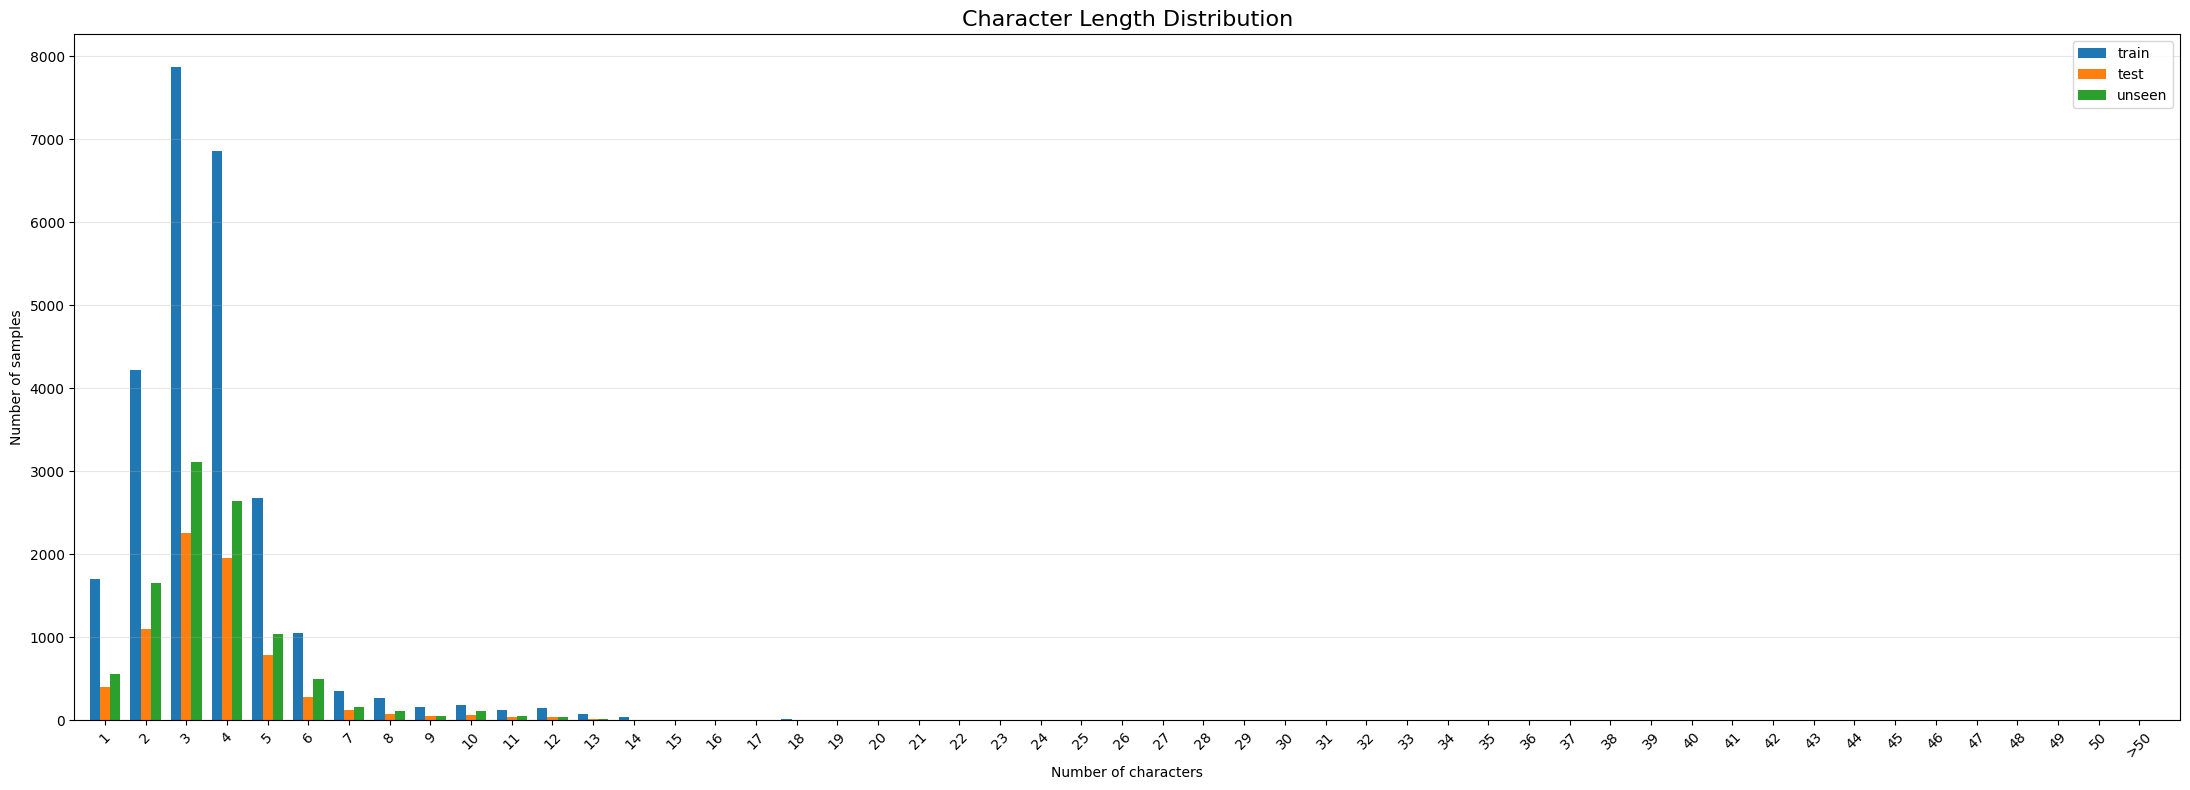

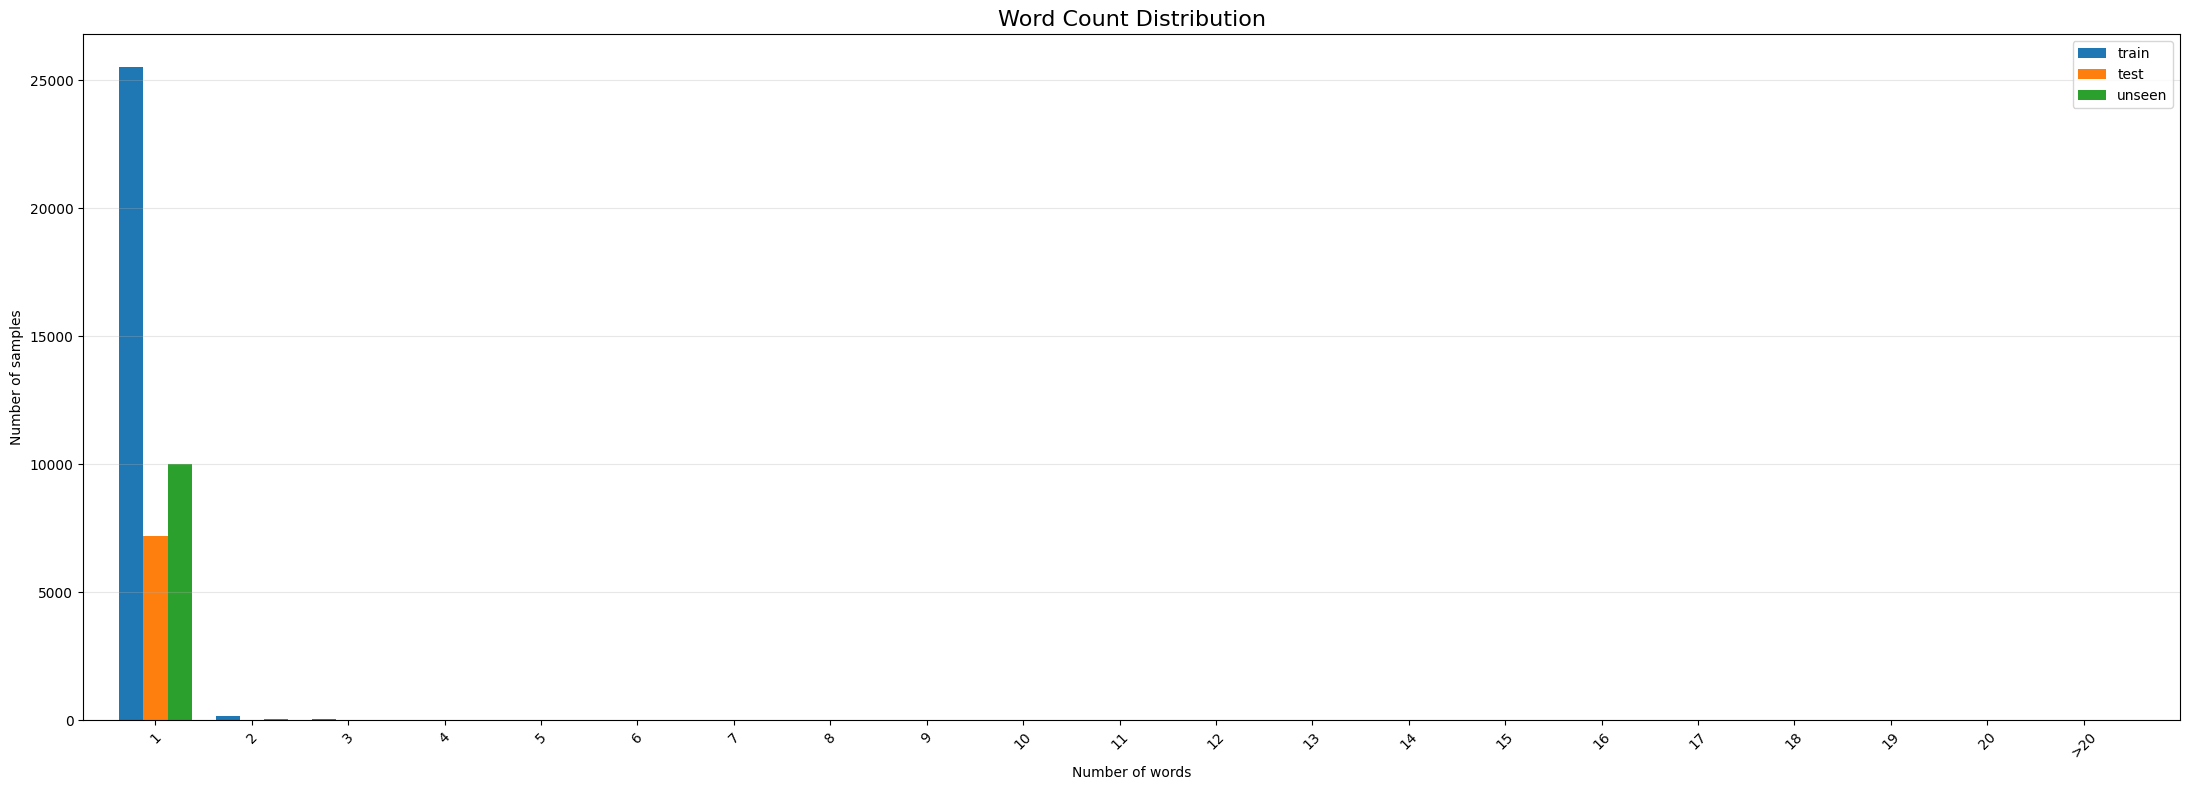


====== Split: Train ======
Original Width:
  samples : 25776
  min     : 2
  max     : 3979
  median  : 47.0
  mode    : 17
  Q1      : 26.00
  Q3      : 92.00
  lower   : 2.00
  upper   : 191.00

Original Height:
  samples : 25776
  min     : 2
  max     : 1418
  median  : 27.0
  mode    : 18
  Q1      : 16.00
  Q3      : 52.00
  lower   : 2.00
  upper   : 106.00


====== Split: Test ======
Original Width:
  samples : 7201
  min     : 3
  max     : 2194
  median  : 47
  mode    : 21
  Q1      : 26.00
  Q3      : 89.00
  lower   : 3.00
  upper   : 183.50

Original Height:
  samples : 7201
  min     : 4
  max     : 1062
  median  : 26
  mode    : 18
  Q1      : 16.00
  Q3      : 47.00
  lower   : 4.00
  upper   : 93.50


====== Split: Unseen ======
Original Width:
  samples : 10068
  min     : 3
  max     : 3935
  median  : 51.0
  mode    : 20
  Q1      : 28.00
  Q3      : 99.00
  lower   : 3.00
  upper   : 205.50

Original Height:
  samples : 10068
  min     : 2
  max     : 1124
  med

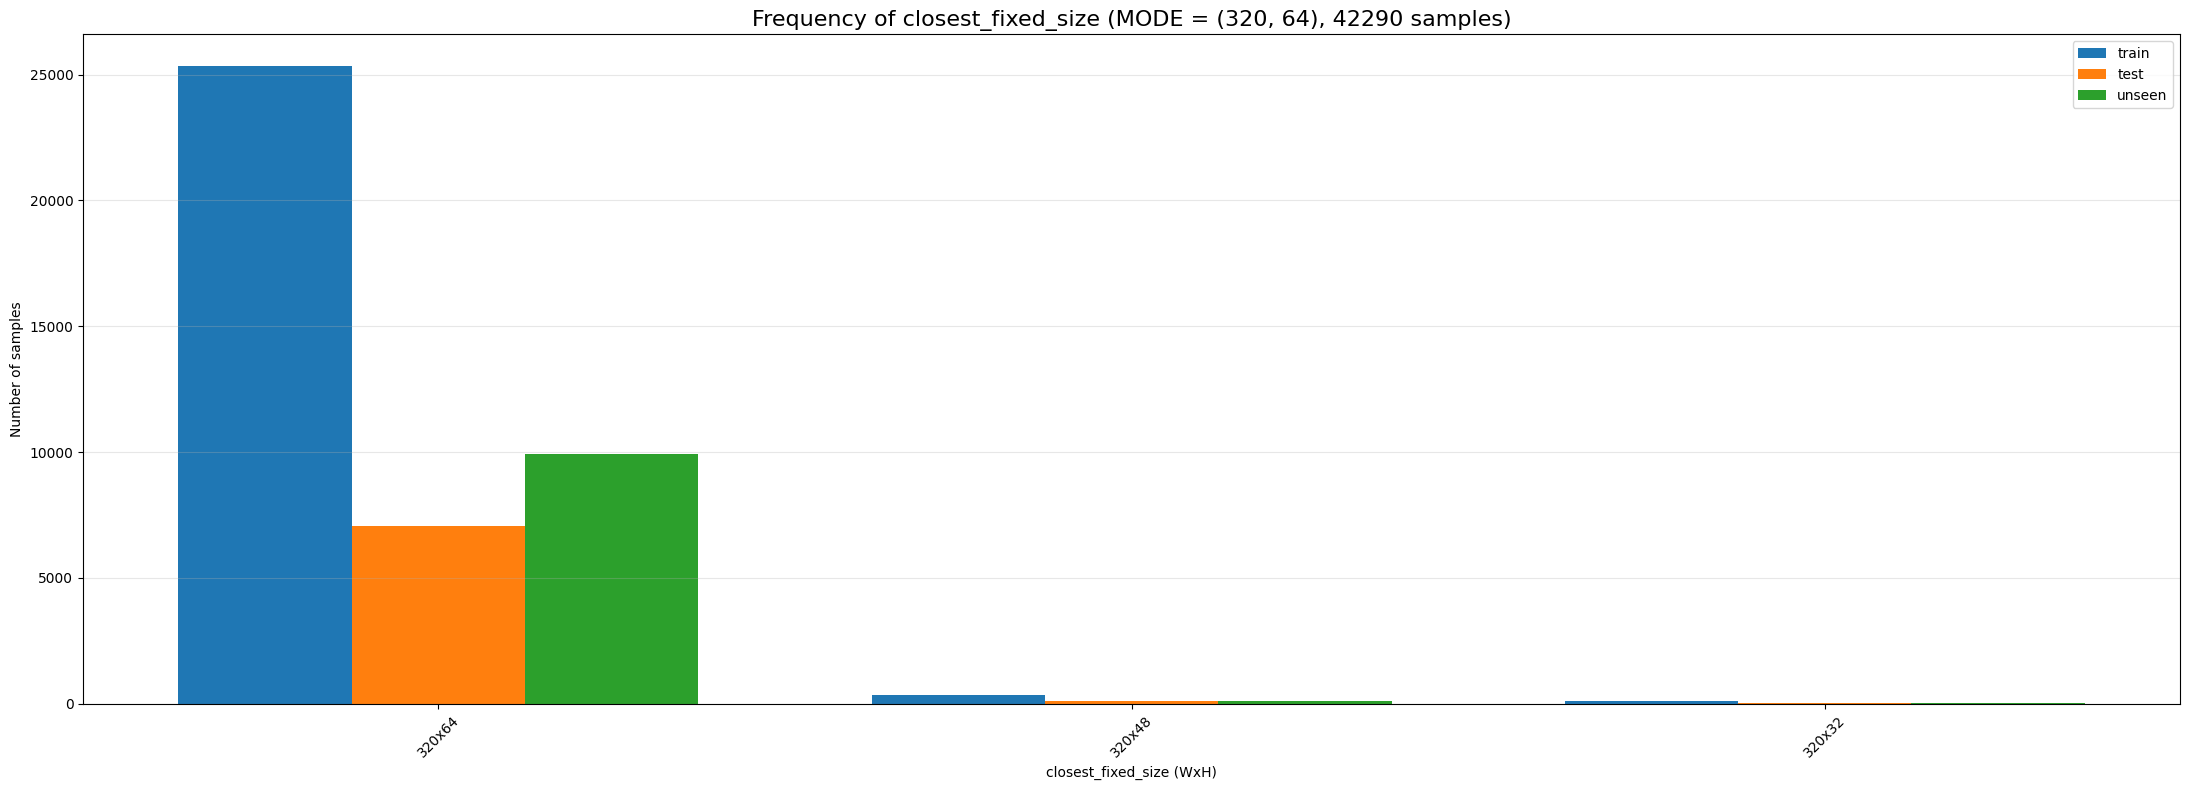

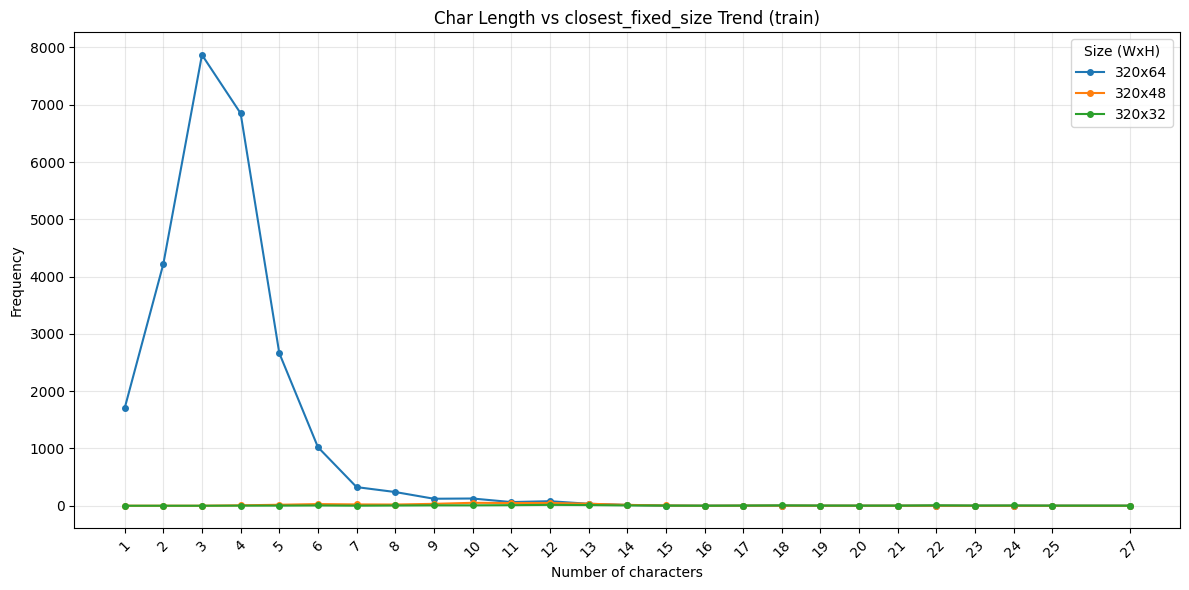

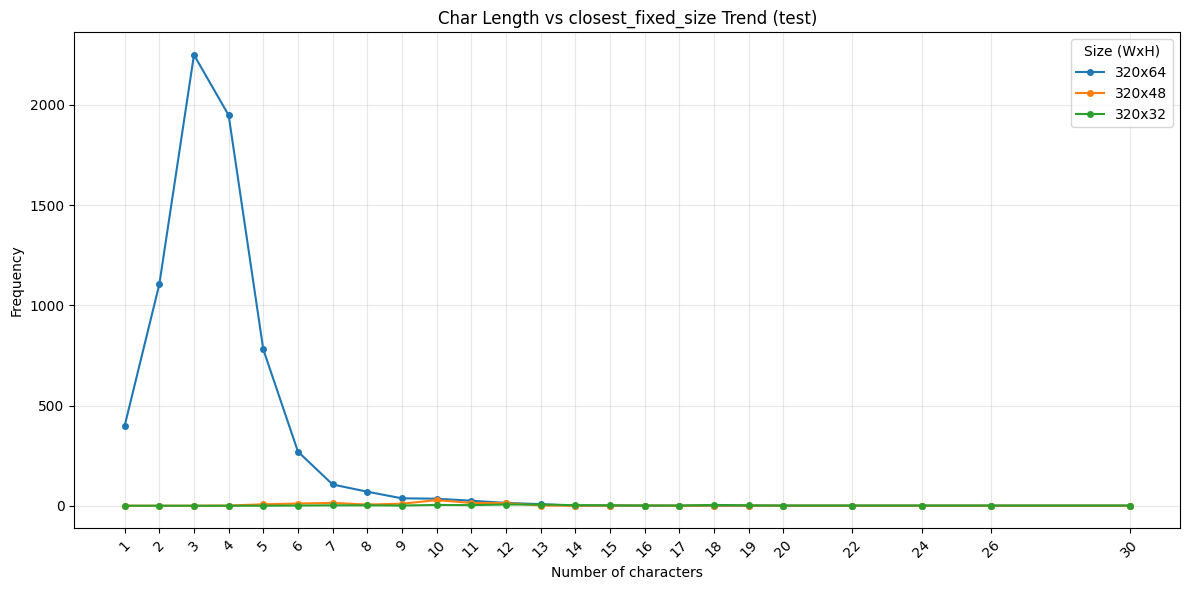

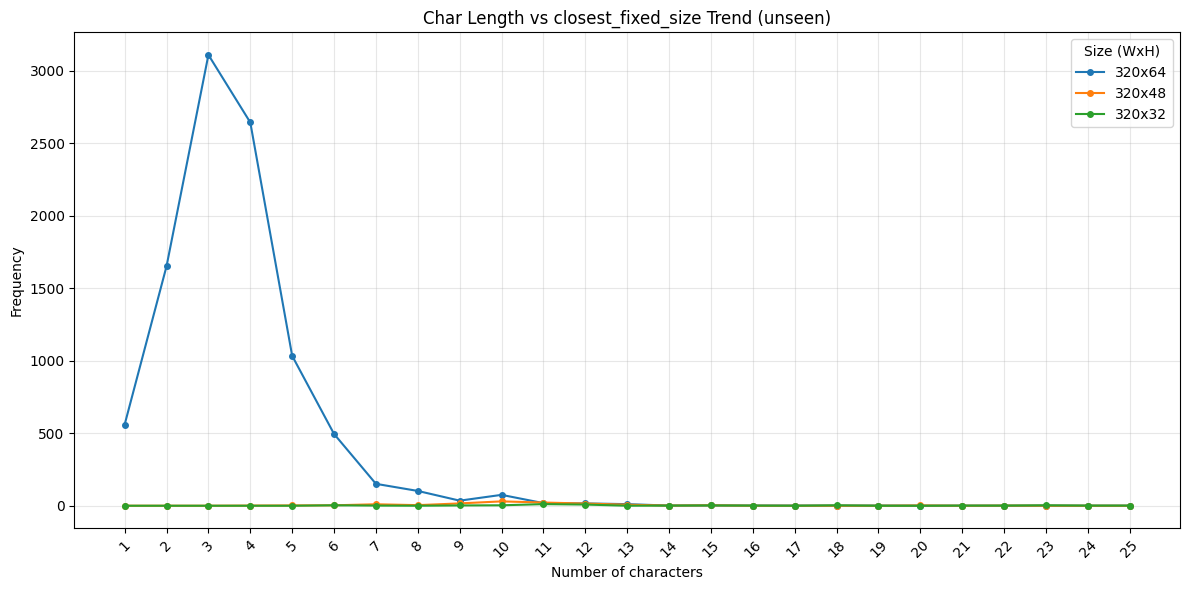

In [24]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["word"])

===== Train =====
<= 25 chars:   5739 samples   82.4%
 > 25 chars:   1230 samples   17.6%
         Q1:    9.0 chars
         Q2:   16.0 chars
         Q3:   22.0 chars
Lower Limit:      3 chars
Upper Limit:   41.5 chars
        Min:      3 chars
        Max:    119 chars

===== Test =====
<= 25 chars:   1308 samples   80.6%
 > 25 chars:    314 samples   19.4%
         Q1:   11.0 chars
         Q2:   16.0 chars
         Q3:   23.0 chars
Lower Limit:      3 chars
Upper Limit:   41.0 chars
        Min:      3 chars
        Max:     85 chars

===== Unseen =====
<= 25 chars:   1982 samples   81.2%
 > 25 chars:    458 samples   18.8%
         Q1:   10.0 chars
         Q2:   16.0 chars
         Q3:   23.0 chars
Lower Limit:      3 chars
Upper Limit:   42.5 chars
        Min:      3 chars
        Max:    121 chars



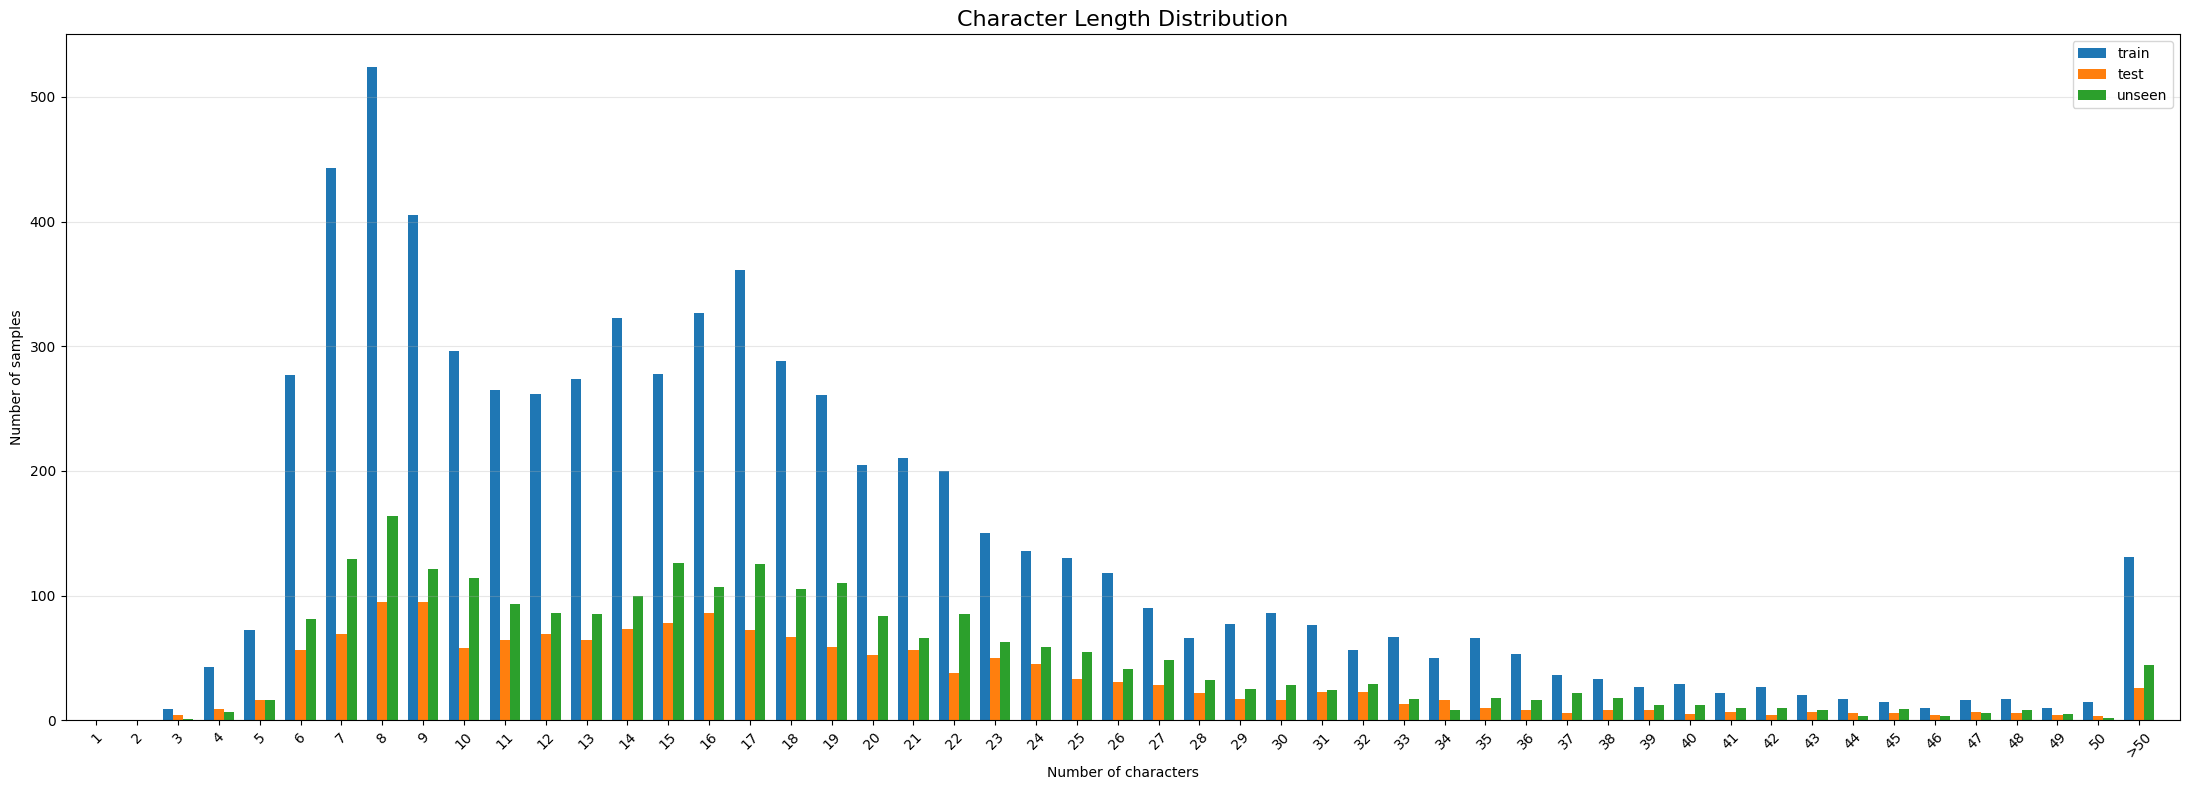

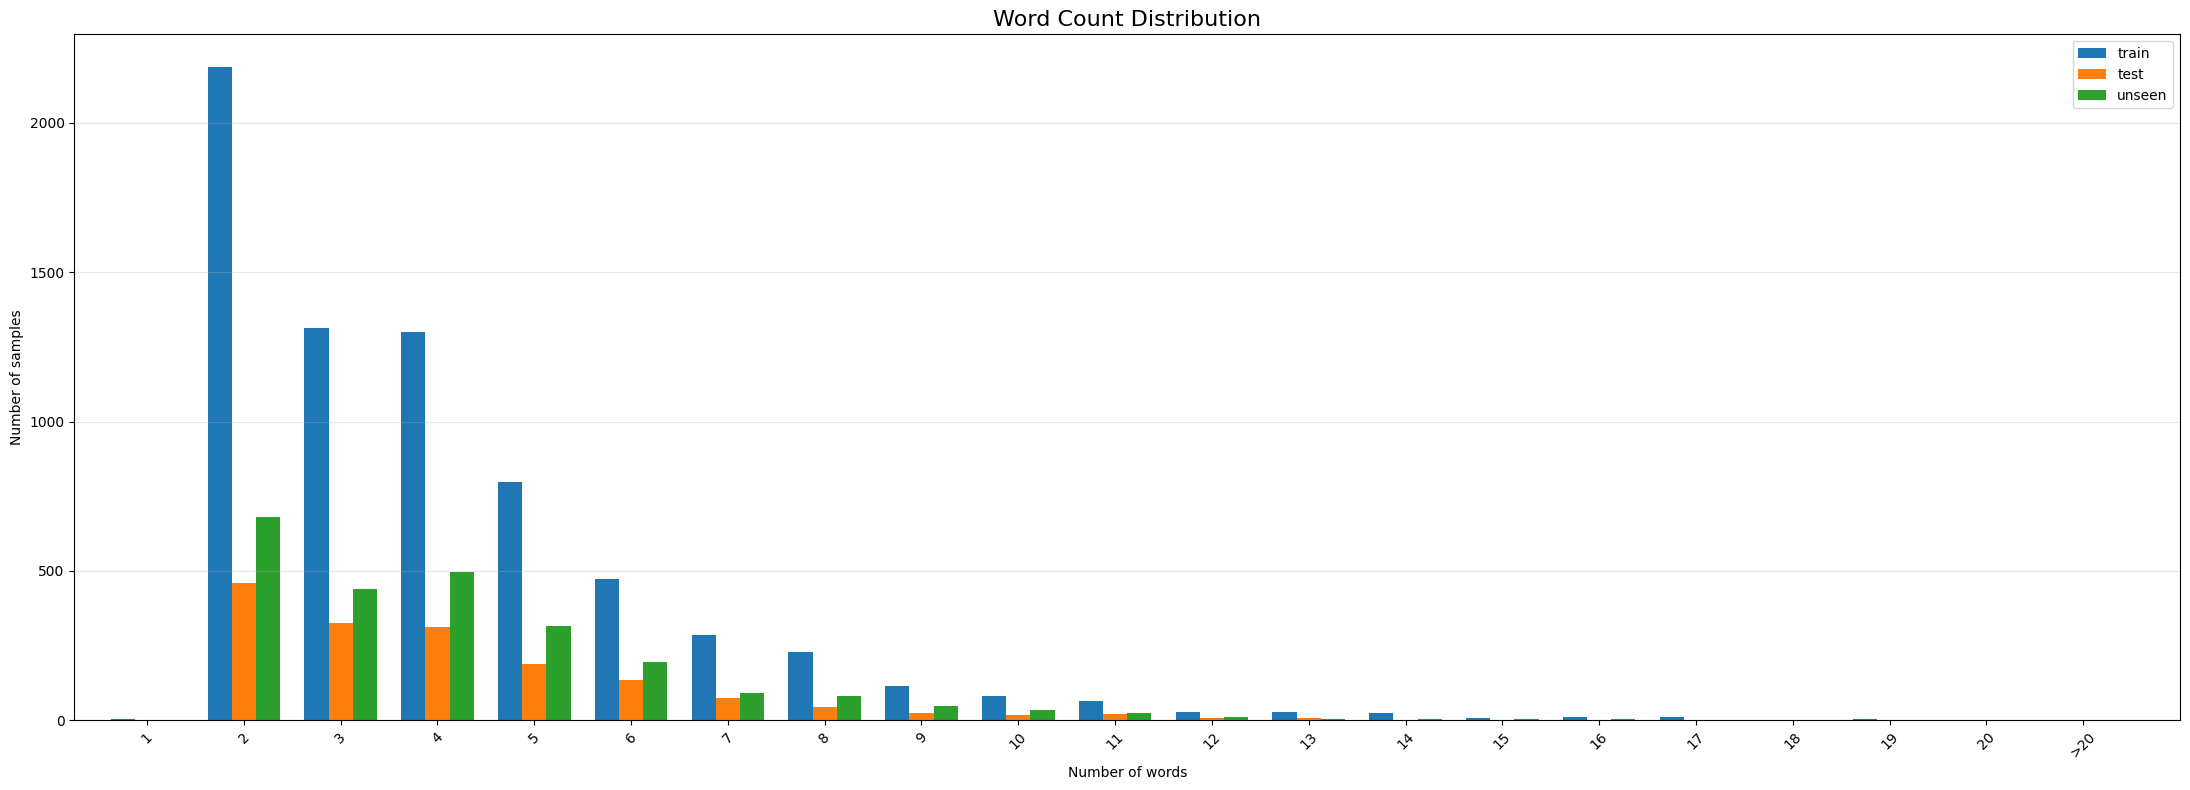


====== Split: Train ======
Original Width:
  samples : 6969
  min     : 12
  max     : 4530
  median  : 212
  mode    : 173
  Q1      : 127.00
  Q3      : 369.00
  lower   : 12.00
  upper   : 732.00

Original Height:
  samples : 6969
  min     : 5
  max     : 887
  median  : 34
  mode    : 20
  Q1      : 21.00
  Q3      : 60.00
  lower   : 5.00
  upper   : 118.50


====== Split: Test ======
Original Width:
  samples : 1622
  min     : 29
  max     : 2798
  median  : 210.0
  mode    : 129
  Q1      : 132.00
  Q3      : 368.50
  lower   : 29.00
  upper   : 723.25

Original Height:
  samples : 1622
  min     : 6
  max     : 1060
  median  : 32.0
  mode    : 23
  Q1      : 20.00
  Q3      : 56.00
  lower   : 6.00
  upper   : 110.00


====== Split: Unseen ======
Original Width:
  samples : 2440
  min     : 19
  max     : 3532
  median  : 234.5
  mode    : 157
  Q1      : 141.00
  Q3      : 407.25
  lower   : 19.00
  upper   : 806.62

Original Height:
  samples : 2440
  min     : 7
  max   

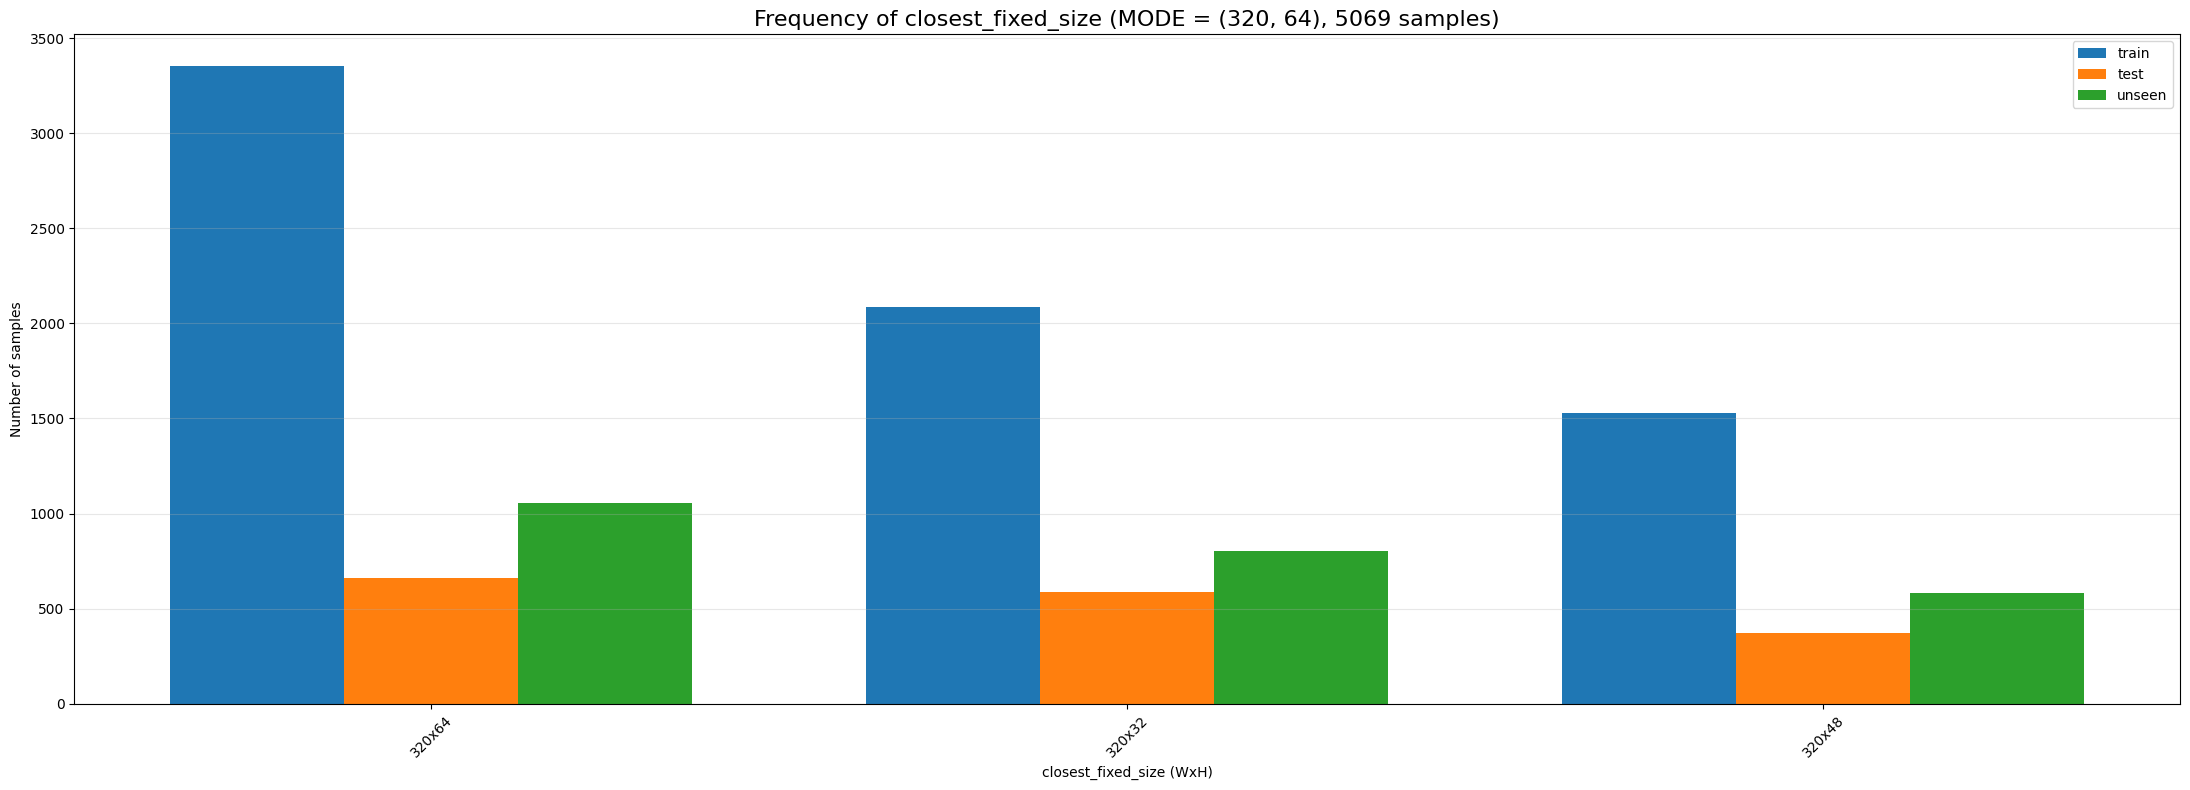

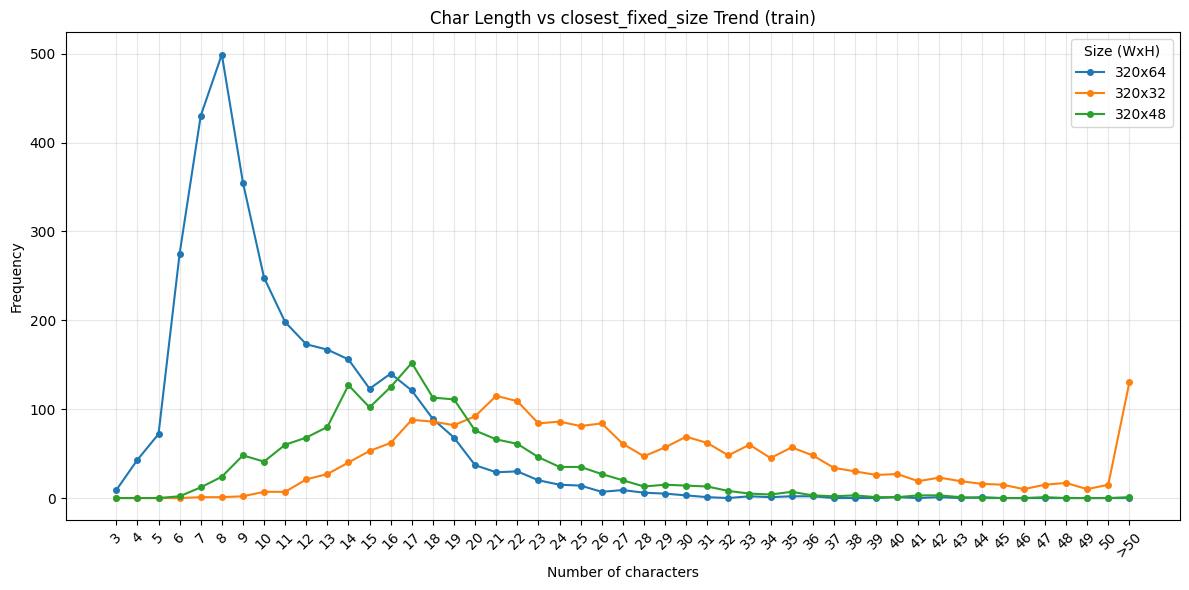

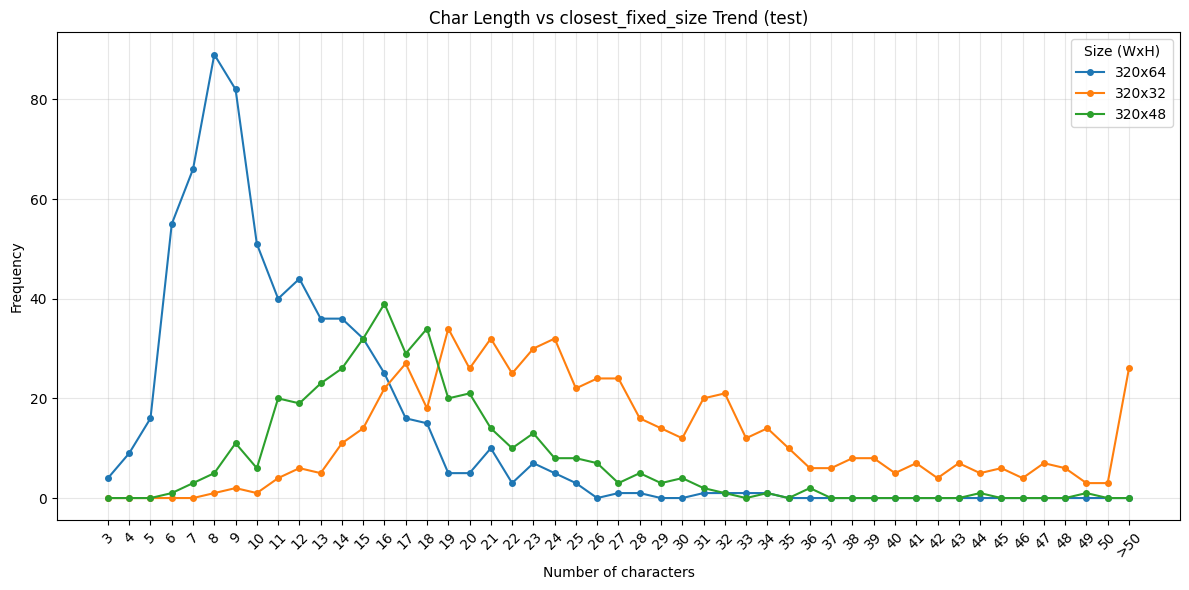

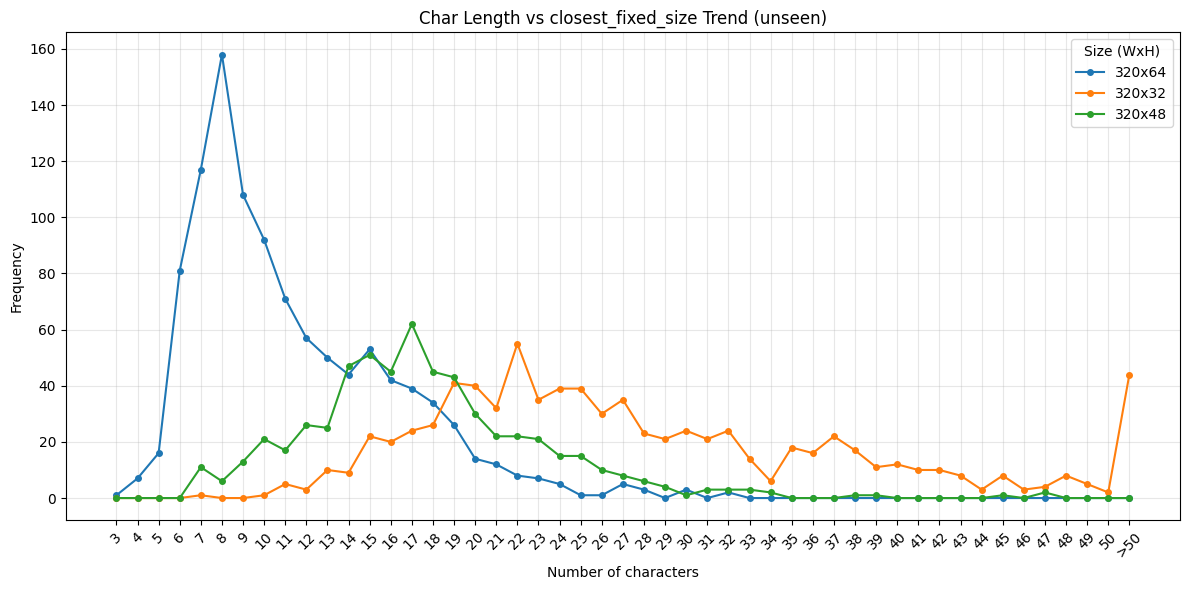

In [25]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["textline"])

===== Train =====
<= 25 chars:      0 samples    0.0%
 > 25 chars:    329 samples  100.0%
         Q1:   43.0 chars
         Q2:   48.0 chars
         Q3:   57.0 chars
Lower Limit:     40 chars
Upper Limit:   78.0 chars
        Min:     40 chars
        Max:    119 chars

===== Test =====
<= 25 chars:      0 samples    0.0%
 > 25 chars:     85 samples  100.0%
         Q1:   43.0 chars
         Q2:   47.0 chars
         Q3:   52.0 chars
Lower Limit:     40 chars
Upper Limit:   65.5 chars
        Min:     40 chars
        Max:     85 chars

===== Unseen =====
<= 25 chars:      0 samples    0.0%
 > 25 chars:    120 samples  100.0%
         Q1:   42.0 chars
         Q2:   47.0 chars
         Q3:   54.0 chars
Lower Limit:     40 chars
Upper Limit:   72.0 chars
        Min:     40 chars
        Max:    121 chars



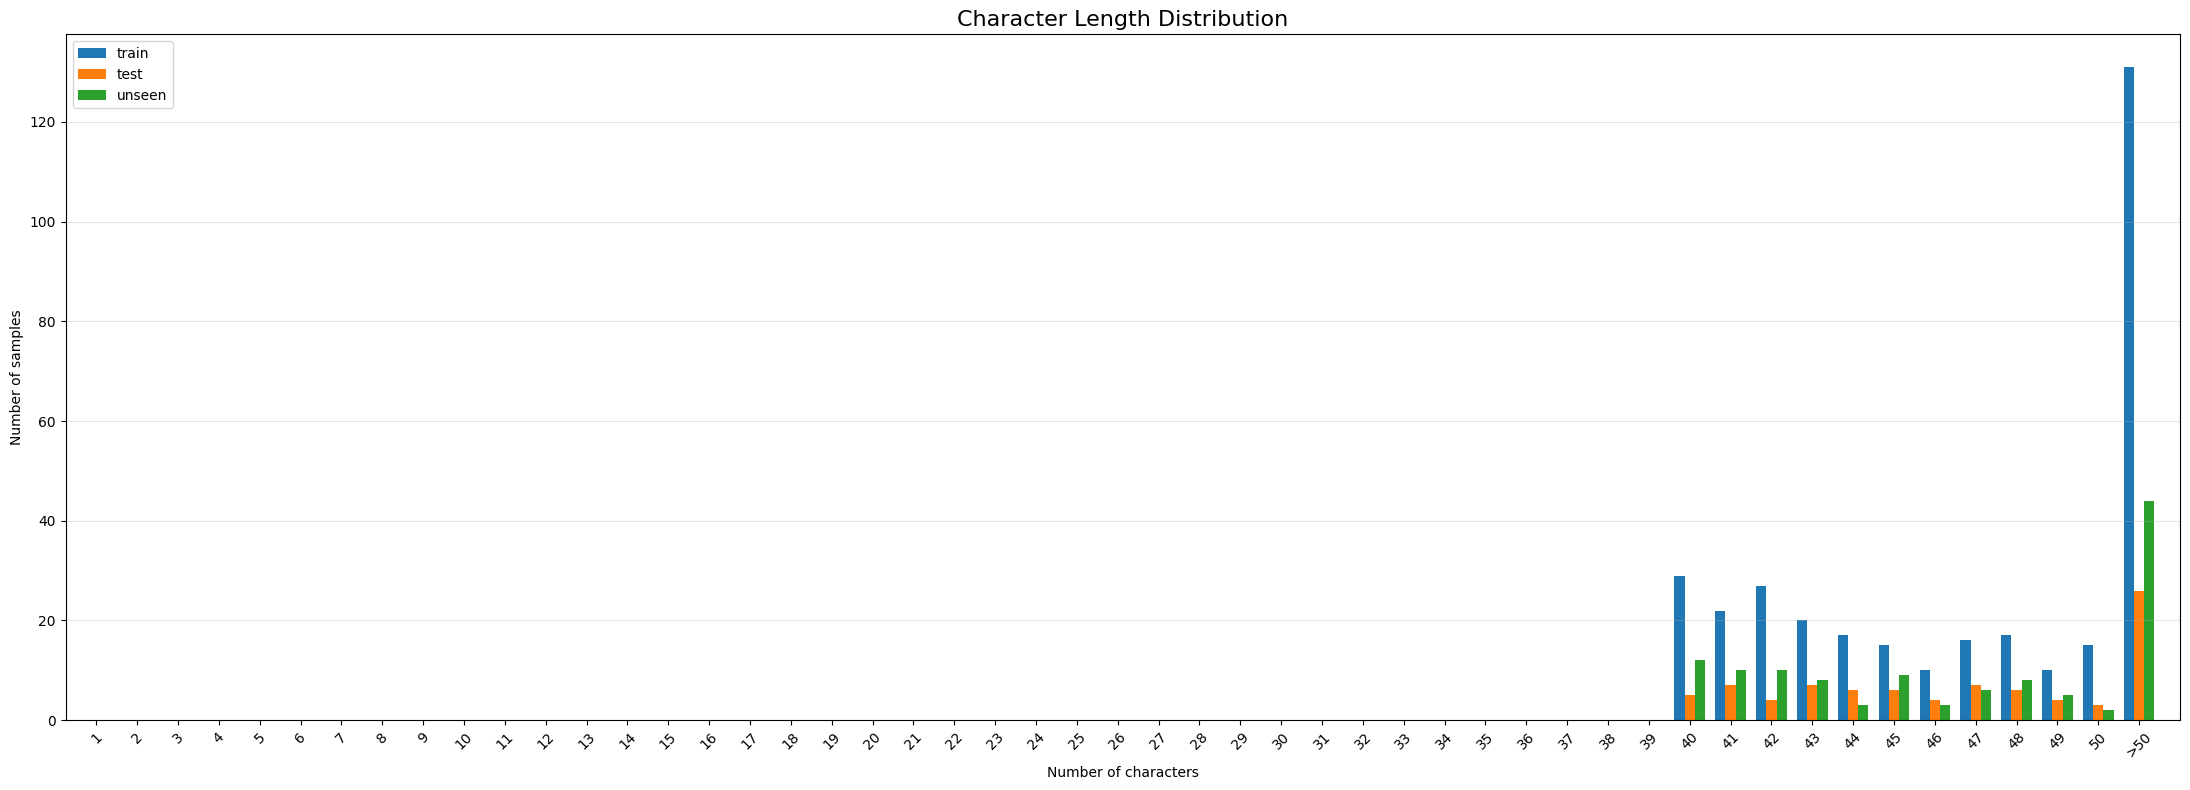

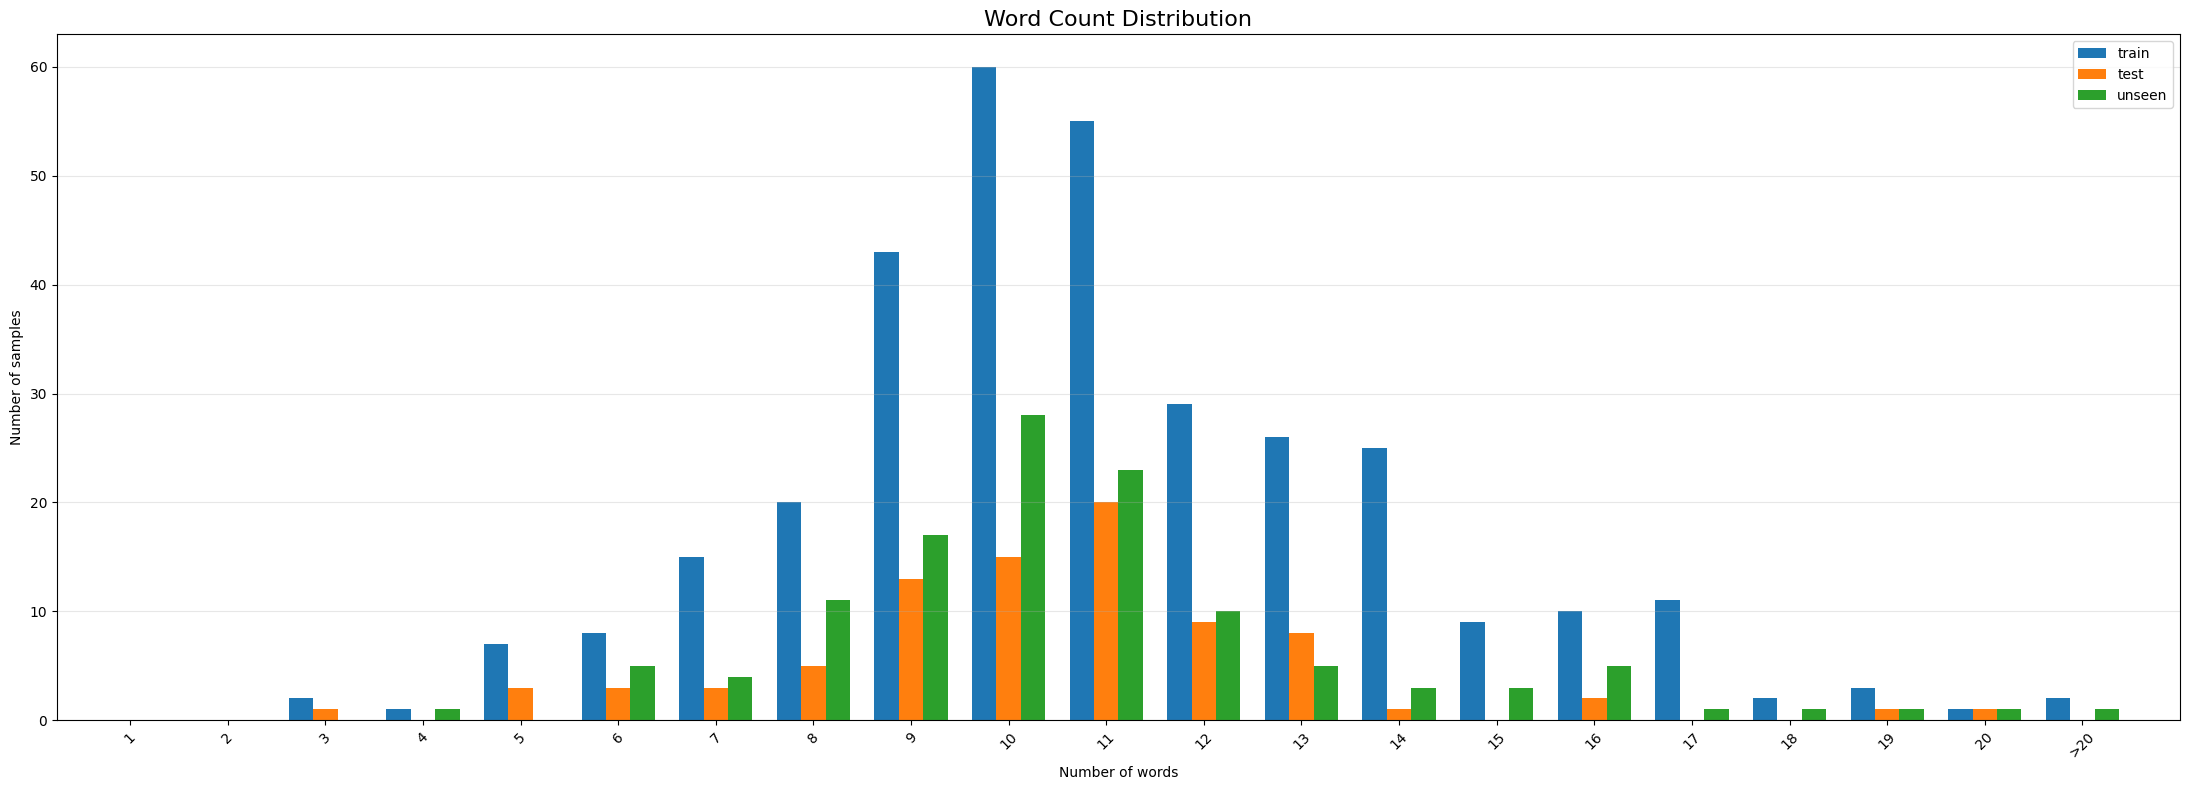


====== Split: Train ======
Original Width:
  samples : 329
  min     : 108
  max     : 3839
  median  : 448
  mode    : 402
  Q1      : 327.00
  Q3      : 705.00
  lower   : 108.00
  upper   : 1272.00

Original Height:
  samples : 329
  min     : 10
  max     : 182
  median  : 27
  mode    : 20
  Q1      : 20.00
  Q3      : 43.00
  lower   : 10.00
  upper   : 77.50


====== Split: Test ======
Original Width:
  samples : 85
  min     : 182
  max     : 1811
  median  : 422
  mode    : 539
  Q1      : 270.00
  Q3      : 695.00
  lower   : 182.00
  upper   : 1332.50

Original Height:
  samples : 85
  min     : 12
  max     : 196
  median  : 25
  mode    : 14
  Q1      : 17.00
  Q3      : 46.00
  lower   : 12.00
  upper   : 89.50


====== Split: Unseen ======
Original Width:
  samples : 120
  min     : 157
  max     : 1790
  median  : 401.0
  mode    : 361
  Q1      : 299.00
  Q3      : 698.00
  lower   : 157.00
  upper   : 1296.50

Original Height:
  samples : 120
  min     : 8
  max     

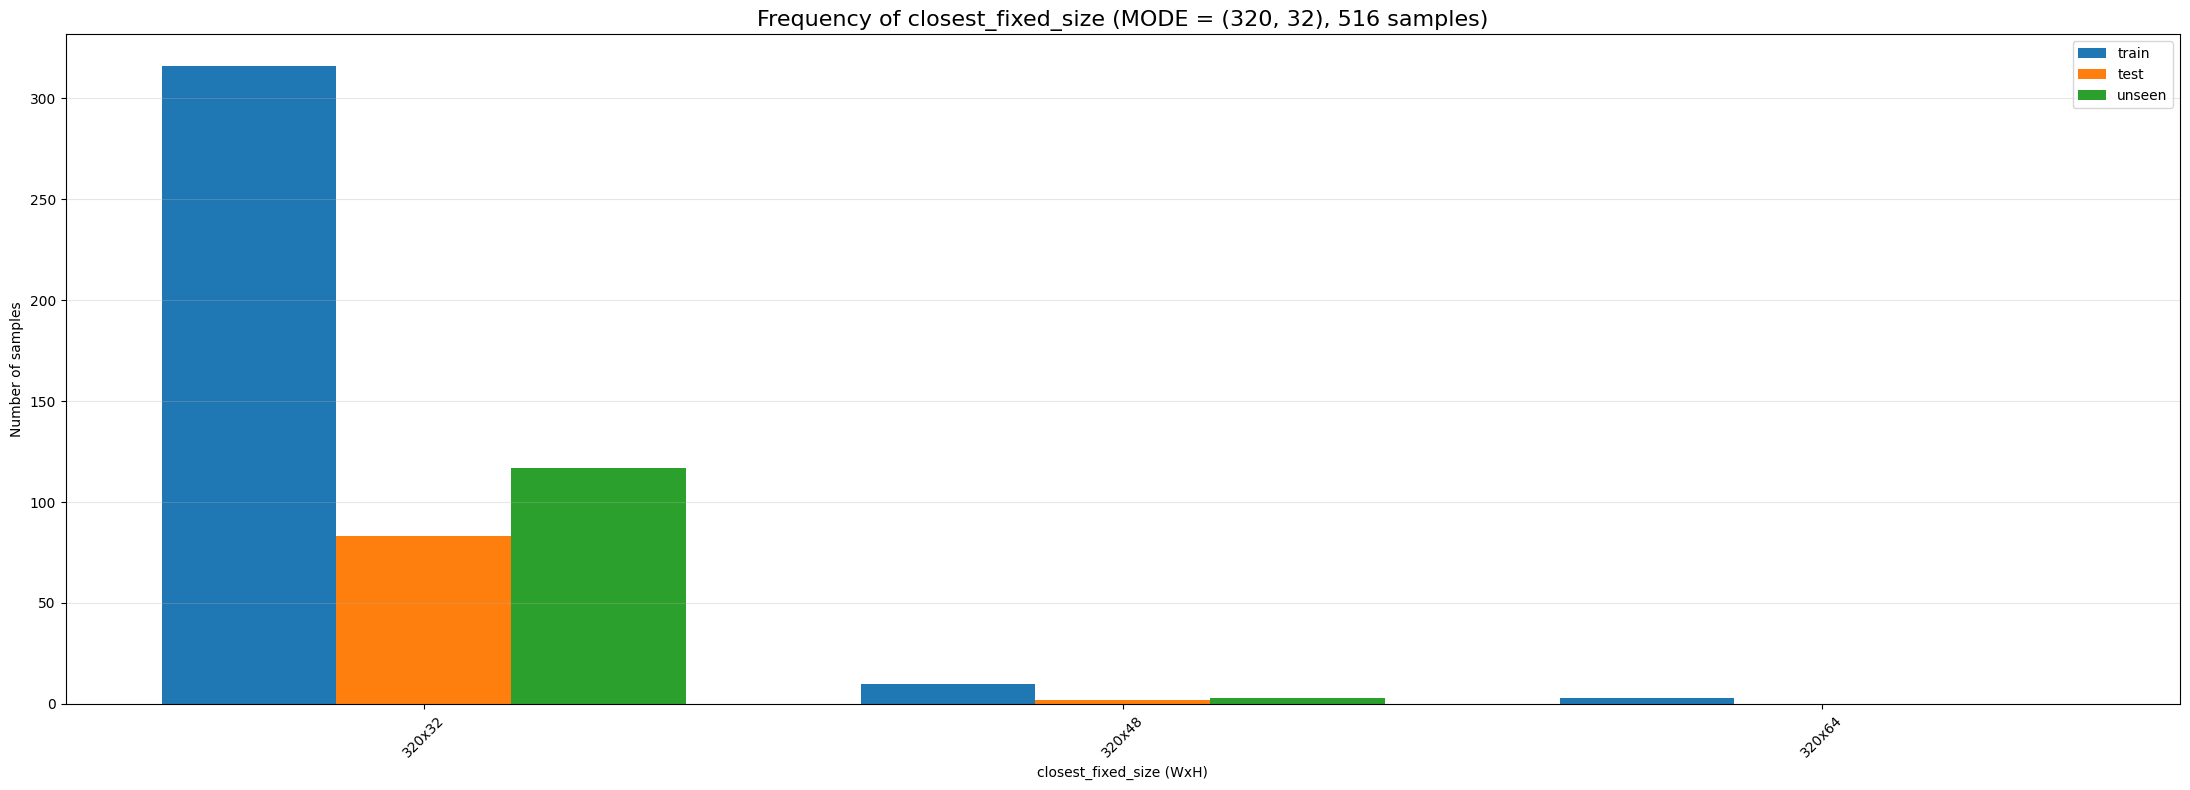

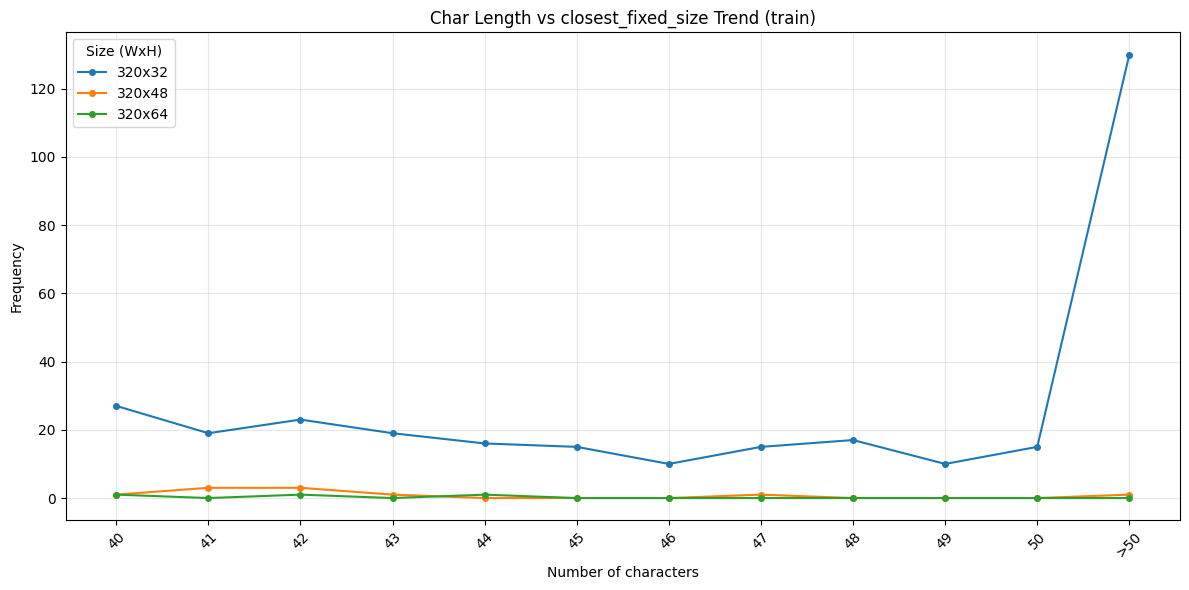

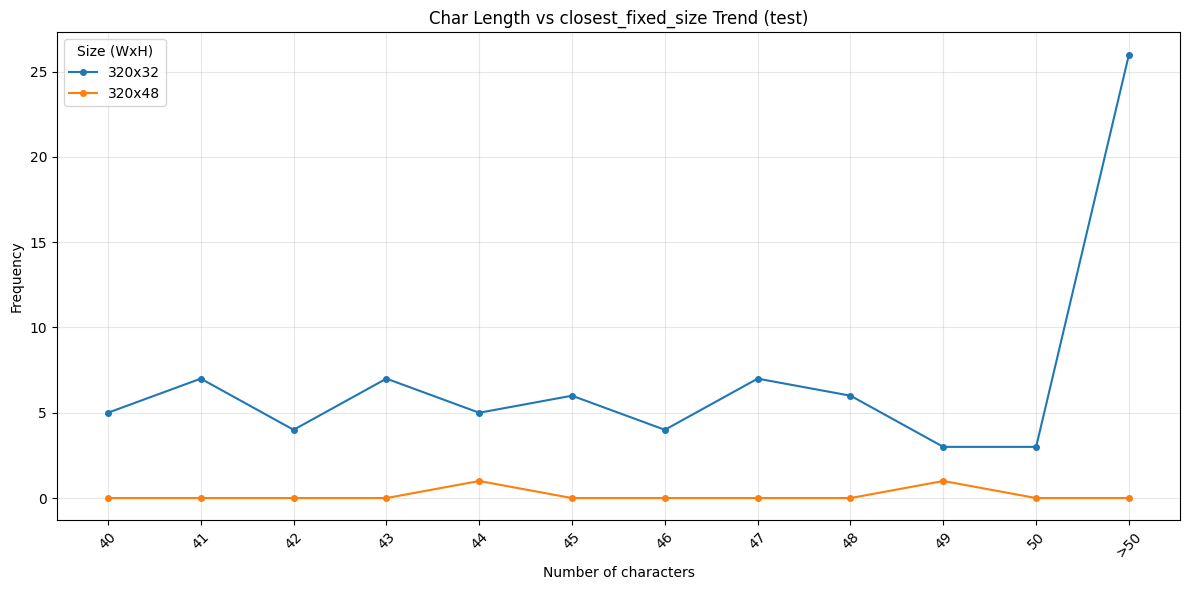

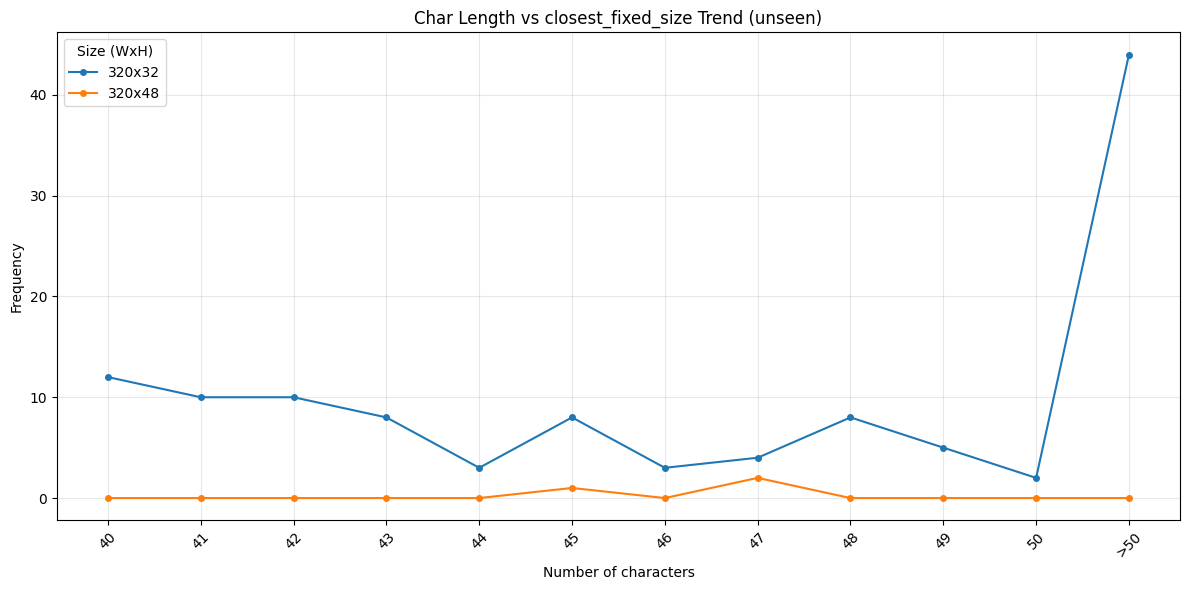

In [27]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["textline"],
 	min_chars=40)

===== Train =====
<= 25 chars:  31514 samples   96.2%
 > 25 chars:   1231 samples    3.8%
         Q1:    3.0 chars
         Q2:    4.0 chars
         Q3:    6.0 chars
Lower Limit:      1 chars
Upper Limit:   10.5 chars
        Min:      1 chars
        Max:    119 chars

===== Test =====
<= 25 chars:   8507 samples   96.4%
 > 25 chars:    316 samples    3.6%
         Q1:    3.0 chars
         Q2:    4.0 chars
         Q3:    6.0 chars
Lower Limit:      1 chars
Upper Limit:   10.5 chars
        Min:      1 chars
        Max:     85 chars

===== Unseen =====
<= 25 chars:  12050 samples   96.3%
 > 25 chars:    458 samples    3.7%
         Q1:    3.0 chars
         Q2:    4.0 chars
         Q3:    6.0 chars
Lower Limit:      1 chars
Upper Limit:   10.5 chars
        Min:      1 chars
        Max:    121 chars



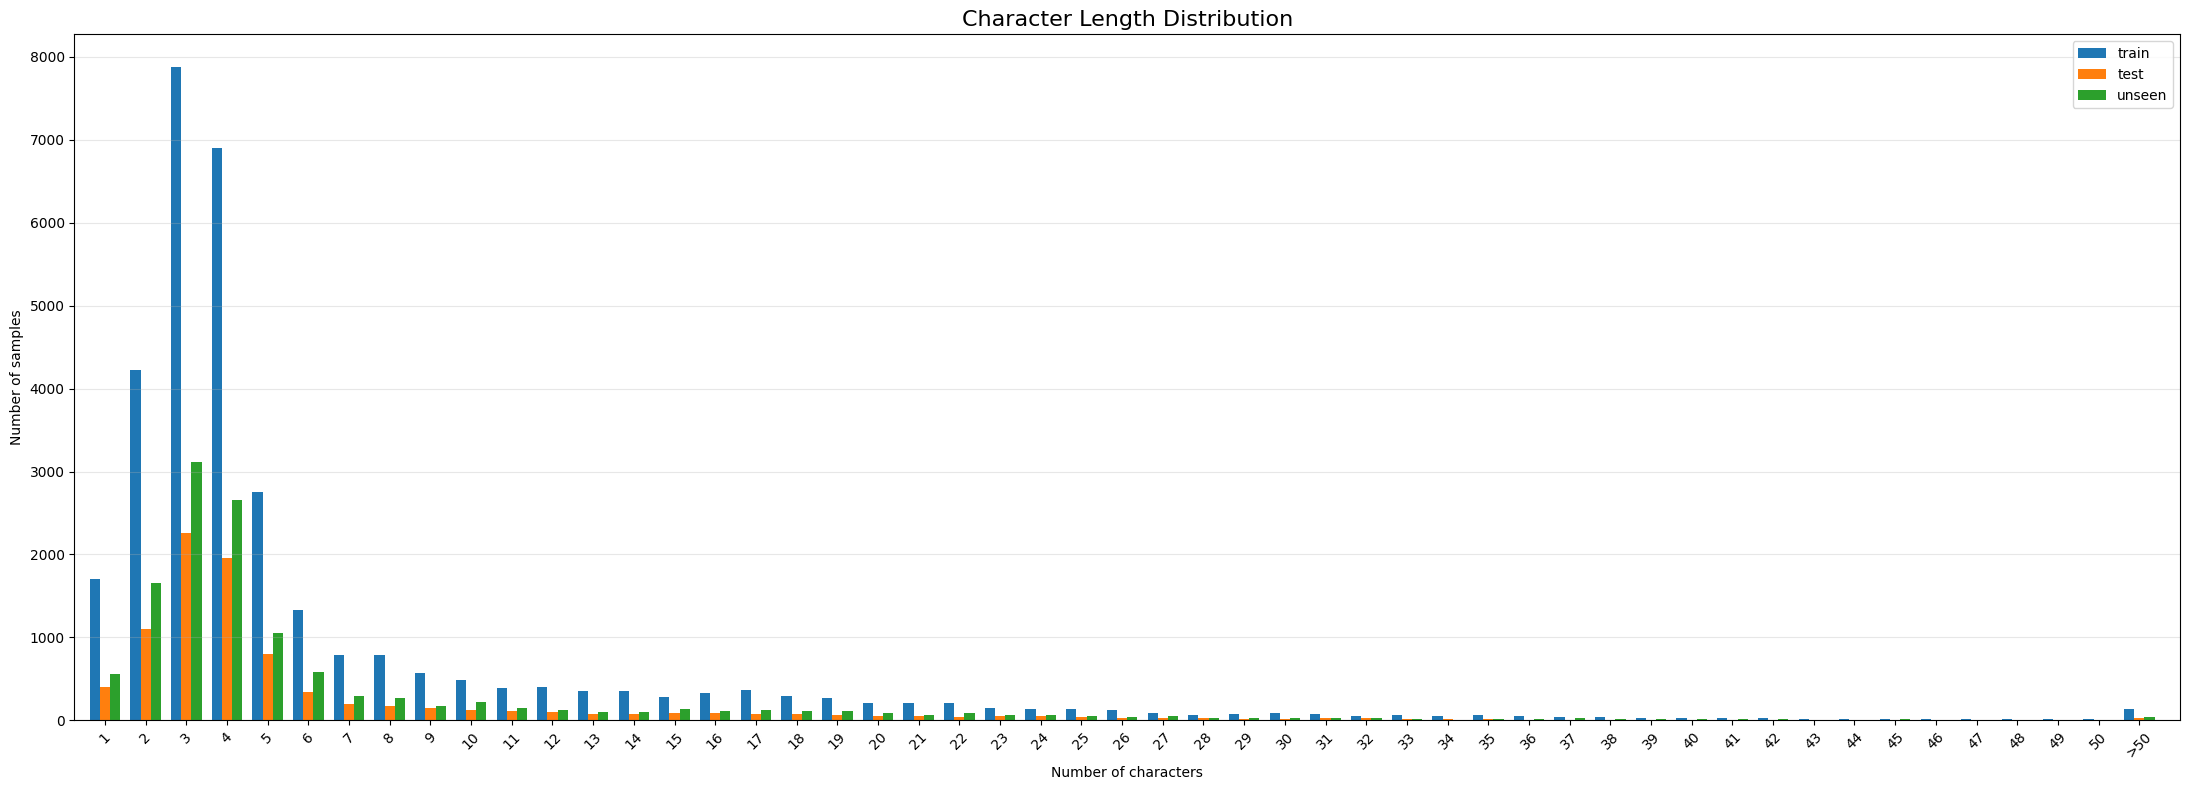

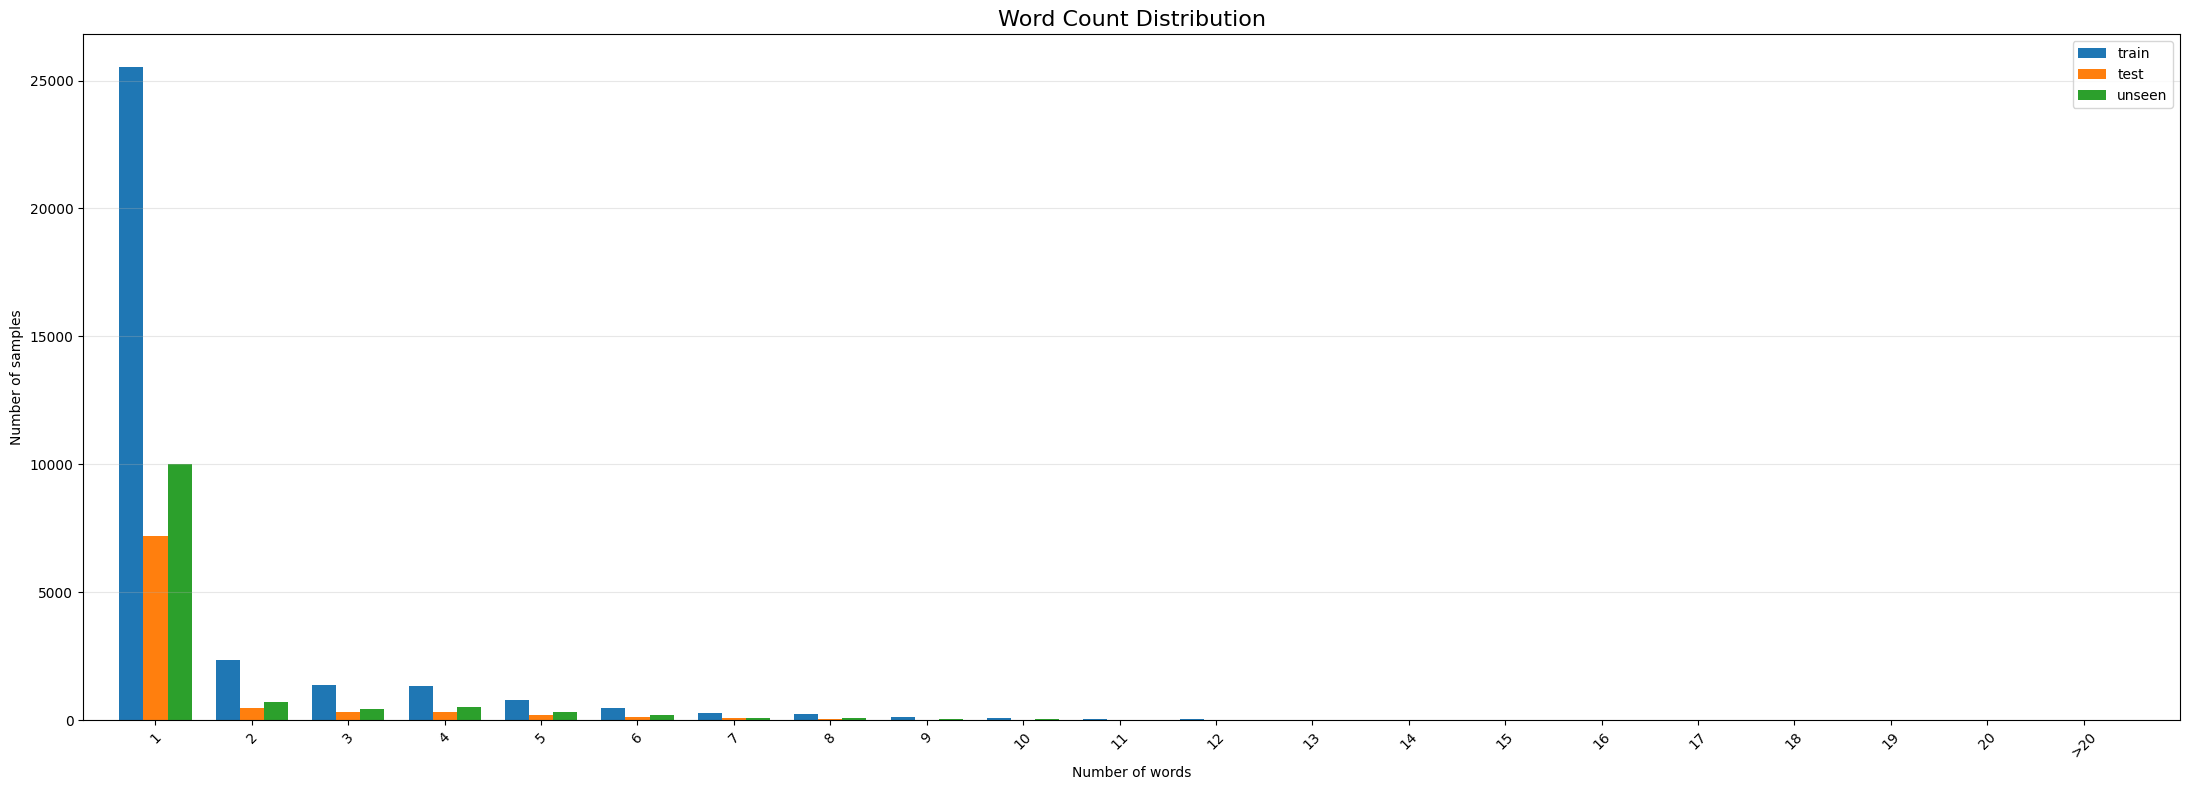


====== Split: Train ======
Original Width:
  samples : 32745
  min     : 2
  max     : 4530
  median  : 63
  mode    : 28
  Q1      : 30.00
  Q3      : 149.00
  lower   : 2.00
  upper   : 327.50

Original Height:
  samples : 32745
  min     : 2
  max     : 1418
  median  : 29
  mode    : 18
  Q1      : 17.00
  Q3      : 54.00
  lower   : 2.00
  upper   : 109.50


====== Split: Test ======
Original Width:
  samples : 8823
  min     : 3
  max     : 2798
  median  : 60
  mode    : 21
  Q1      : 30.00
  Q3      : 134.00
  lower   : 3.00
  upper   : 290.00

Original Height:
  samples : 8823
  min     : 4
  max     : 1062
  median  : 27
  mode    : 18
  Q1      : 17.00
  Q3      : 49.00
  lower   : 4.00
  upper   : 97.00


====== Split: Unseen ======
Original Width:
  samples : 12508
  min     : 3
  max     : 3935
  median  : 66.0
  mode    : 20
  Q1      : 33.00
  Q3      : 155.00
  lower   : 3.00
  upper   : 338.00

Original Height:
  samples : 12508
  min     : 2
  max     : 1124
  medi

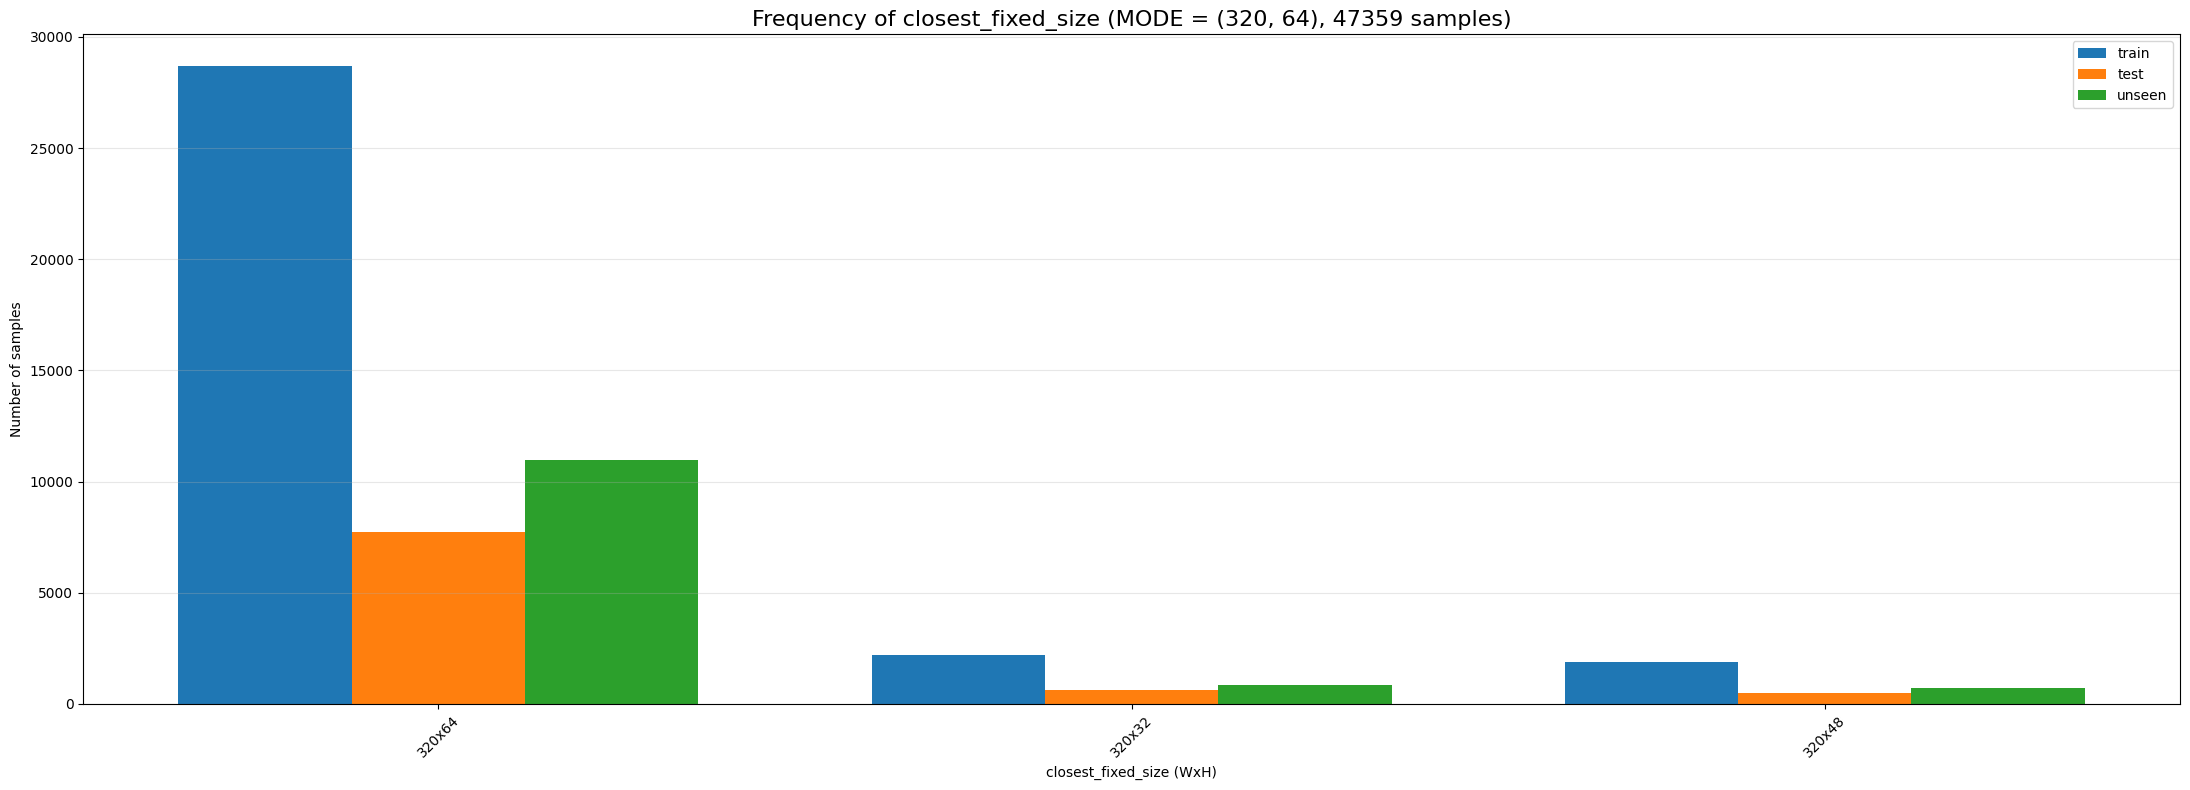

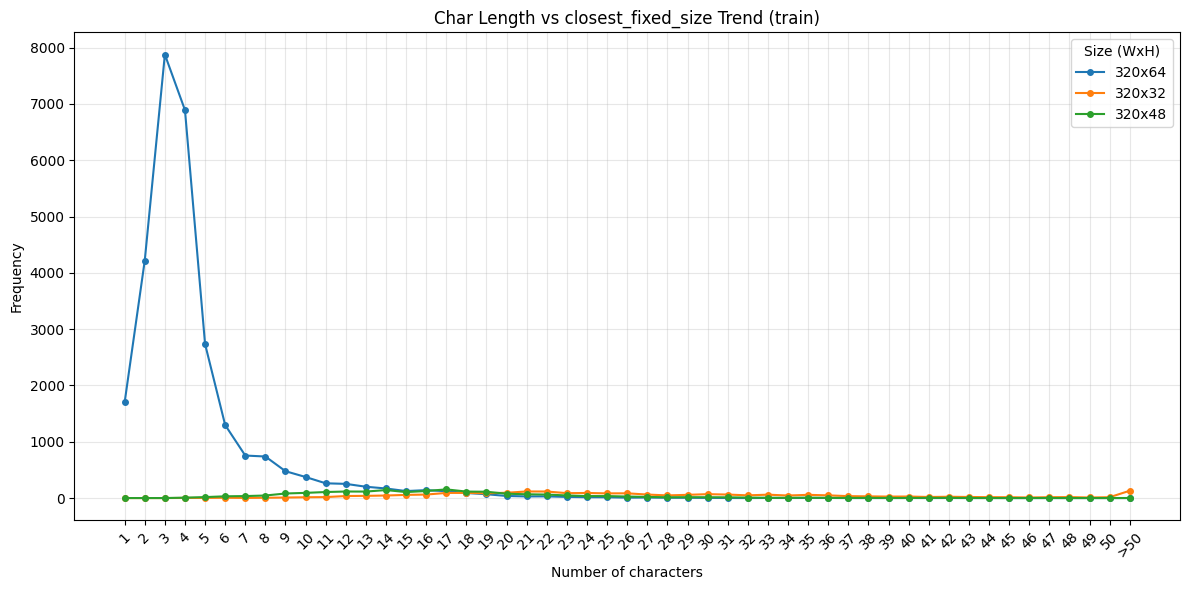

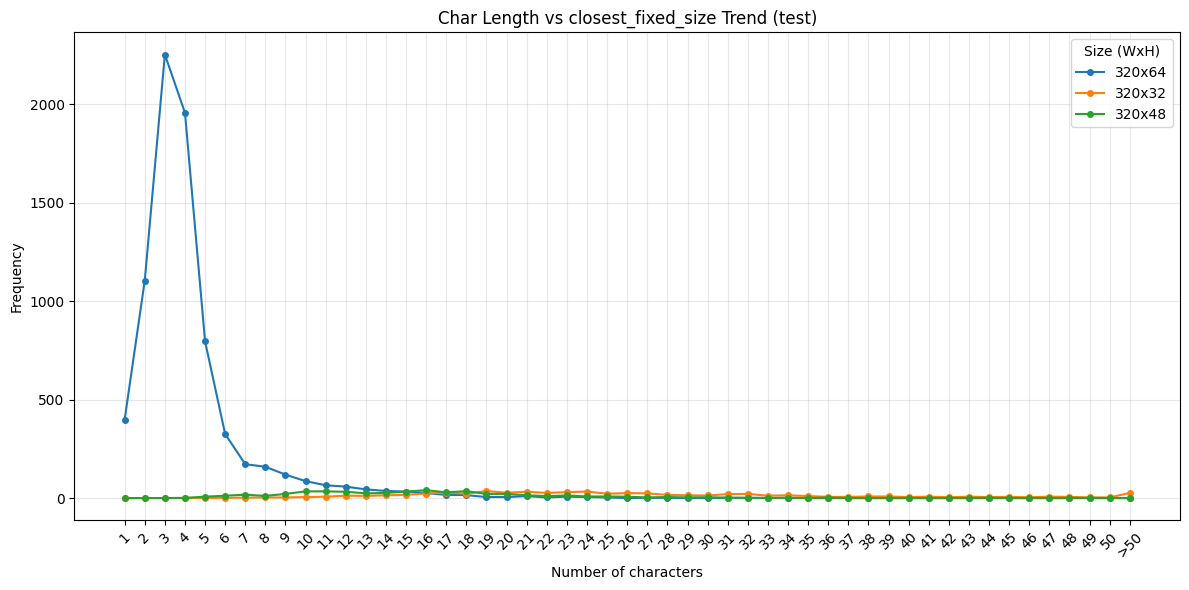

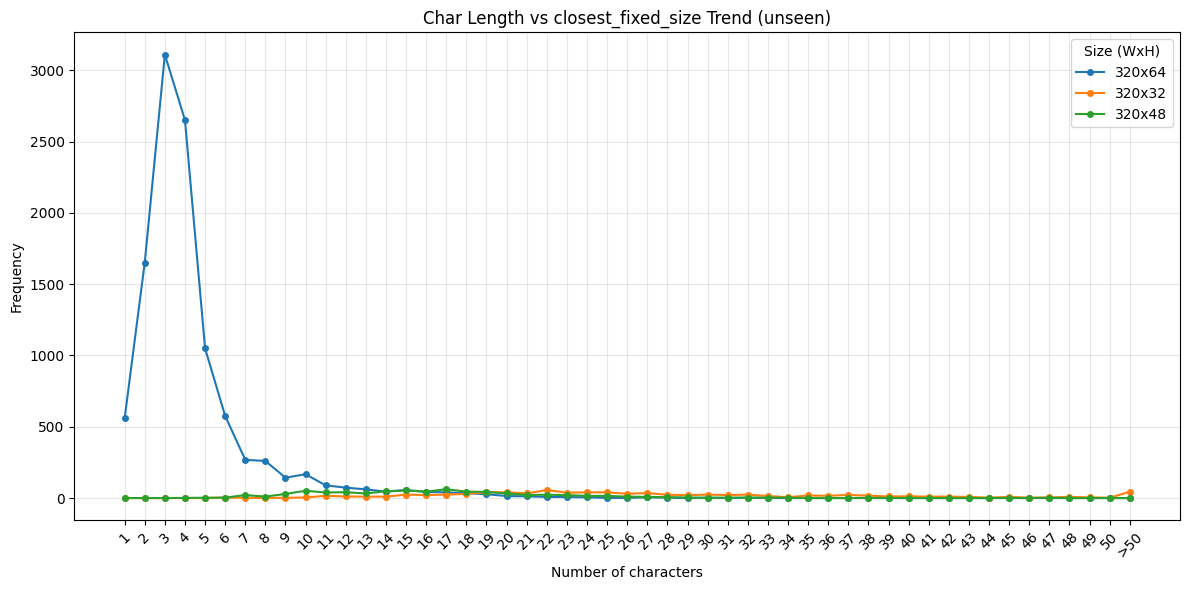

In [14]:
filter_and_plot_across_splits(
	results_dict=data_statistic,
	keywords=["word", "textline"])

**Sumary**

| Dataset                 | Condition        | Most Popular Size |
|-------------------------|------------------|-------------------|
| Word                    | —                | 320 × 64          |
| Text line               | —                | 320 × 64          |
| Word & Text line        | —                | 320 × 64          |
| Text line               | 40+ chars        | **320 × 32**      |


